# Estudio de los datos de Ventas de una Ferretería

Autor: Diana Chacón Ocariz

## Contexto:

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).


## Objetivos del negocio:

**Tener mayor visibilidad sobre las ventas para poder mejorar el proceso de compras y la toma de decisiones en general:** 

    - Poder analizar objetivamente las ventas
    - Determinar los productos que podrían entrar en rotura de stock al final del período
    - Identificar los productos menos vendidos
    - Identificar patrones en el comportamiento de las ventas para poder hacer predicciones de ventas
    

## Objetivos académicos:

    - Estudiar un caso real, con datos reales y cuyo resultado pueda ayudar a alguien a resolver un problema 
    - Demostrar que la ciencia de datos también puede ayudar a las PYMES
    - Conocer y practicar el uso de herramientas de ciencia de datos
    
## Fuentes de datos:

Los datos provienen de reportes sacados del software de gestión de la empresa. Se trata de archivos .xls que contienen sólo los datos de reportes sobre ventas por producto (2021 y 2022) y el stock al final del período. 

# Notebook 2: EDA: Análisis y Visualización

Recuperamos los datos (ya limpios) de los archivos **parquet** para comenzar un análisis más profundo de los datos, responder preguntas del negocio, verificar si hay patrones en las ventas y preparar los datos para utilizarlos en modelos predictivos.

Utilizaremos varias librerías de visualización con el fin de compararlas: **Matplotlib, Seaborn y Altair**

In [1]:
# Librerías utilizadas
# ==============================================================================

# Librerías para el manejo de directorios
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd

# Librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

%matplotlib inline


In [2]:
# Definición de los colores para los gráficos
# ==============================================================================

MONTO = '#70c931' 
VOLUMEN = '#2649e8'  
FACTURAS = '#e1db33' 

VERDE = '#99e265' 
AZUL = '#2649e8'  
AMARILLO = '#fff952' 

# Definir colores específicos para cada año
AÑOS = ['2020', '2021', '2022']
COLORES = [VERDE, AZUL, AMARILLO]

In [3]:
# Funciones generales
# ==============================================================================

# Formateado de texto
def formato_titulo(texto):
    subray = '=' * (len(texto))
    print("\033[1;34m"+texto)
    print(subray)
    print("\033[0;m")

In [4]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

In [5]:
%%time 
df_ventas = pd.read_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", engine='fastparquet')
df_ventas

CPU times: user 3.93 s, sys: 127 ms, total: 4.06 s
Wall time: 4.45 s


num          fecha_comp     cliente  vendedor  \
0      2020-0000000001-ne 2020-01-07 11:04:00  18018450.0        13   
1      2020-0000000022-fa 2020-01-07 08:57:00  10747595.0        11   
2      2020-0000000023-fa 2020-01-07 07:52:00  14281493.0         7   
3      2020-0000000024-fa 2020-01-07 09:25:00  19339734.0         7   
4      2020-0000000025-fa 2020-01-07 09:20:00  16788717.0        13   
...                   ...                 ...         ...       ...   
40916  2022-0000006497-fa 2022-02-05 11:55:00  13763788.0        13   
40917  2022-0000006497-fa 2022-02-05 11:55:00  13763788.0        13   
40918  2022-0000006497-fa 2022-02-05 11:55:00  13763788.0        13   
40919  2022-0000006498-fa 2022-02-05 11:58:00  10743720.0         1   
40920  2022-0000006499-fa 2022-02-07 09:48:00   9339434.0        11   

            monto tipo    cod  \
0       170601.20   ne          
1      1377605.59   fa          
2       623407.20   fa          
3      8520323.59   fa          
4       490901.59   fa          
...           ...  ...    ...   
40916        1.19   fa  00809   
40917        1.66   fa  01398   
40918        6.90   fa  01404   
40919       69.75   fa  04072   
40920      356.00   fa  05329   

                                                producto  cantidad      fecha  \
0                                                              0.0 2020-01-07   
1                                                              0.0 2020-01-07   
2                                                              0.0 2020-01-07   
3                                                              0.0 2020-01-07   
4                                                              0.0 2020-01-07   
...                                                  ...       ...        ...   
40916                          CONFITERIA TORONTO  SAVOY       1.0 2022-02-05   
40917           CONFITERIA PASTILLAS CHAO SANDIA/ CEREZA       1.0 2022-02-05   
40918                             CONFITERIA OREO TUBITO       1.0 2022-02-05   
40919               CERRADURA MANILLA RECTA ALUMINIO TOC       1.0 2022-02-05   
40920  GRIFERIA LAVAPLATOS EXTRAIBLE CURVA CAL 41*22C...       1.0 2022-02-07   

       tasa_dolar  monto_dolar  
0        67581.00     2.524396  
1        67581.00    20.384510  
2        67581.00     9.224593  
3        67581.00   126.075725  
4        67581.00     7.263899  
...           ...          ...  
40916        4.60     0.258696  
40917        4.60     0.360870  
40918        4.60     1.500000  
40919        4.60    15.163043  
40920        4.61    77.223427  

[40921 rows x 12 columns]

# Análisis del DF de ventas

In [6]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40921 entries, 0 to 40920
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   num          40921 non-null  object        
 1   fecha_comp   40921 non-null  datetime64[ns]
 2   cliente      40921 non-null  object        
 3   vendedor     40921 non-null  int64         
 4   monto        40921 non-null  float64       
 5   tipo         40921 non-null  object        
 6   cod          40921 non-null  object        
 7   producto     40921 non-null  object        
 8   cantidad     40921 non-null  float64       
 9   fecha        40921 non-null  datetime64[ns]
 10  tasa_dolar   40921 non-null  float64       
 11  monto_dolar  40921 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 4.1+ MB


## Metadatos

Cada fila del DF corresponde a un producto dentro de una factura (línea de factura):

    - num: Número o referencia de la factura          
    - fecha_comp: Fecha de la factura, en formato datetime
    - cliente: Código del cliente           
    - vendedor: Código del vendedor           
    - cod: Código del producto              
    - producto: Descripción del producto          
    - cantidad: Cantidad de producto dentro de la factura   
    - monto: Monto en Bs (moneda venezolana) del producto
    - tipo: Tipo de la factura              
    - fecha: Fecha de la factura en formato yyyy-mm-dd       
    - tasa_dolar: Tasa de cambio del día        
    - monto_dolar: Monto en USD del producto

Los datos ya han sido limpiados y no hay valores nulos. 

### ¿Qué nos interesa de los datos?

3 variables nos interesan:
 - **cantidad:** Nos da el volumen de ventas (cantidad de productos vendidos).
 - **monto_dolar:** Nos da las ventas en USD.
 - **num:** Nos permite contar la cantidad de ventas o facturas. Puede dar una idea del tráfico de clientes o cuántos clientesha atendido un vendedor dado.
 
Estudiaremos el comportamiento de esas 3 variables en el tiempo.

También analizaremos: 

- Los productos: Productos más vendidos, menos vendidos, promedio de ventas, productos que se venden en grandes cantidades...
- Los vendedores: Ventas por vendedor
- Los clientes: Mejores clientes

In [7]:
df_ventas.describe()

vendedor         monto      cantidad    tasa_dolar   monto_dolar
count  40921.000000  4.092100e+04  40921.000000  4.092100e+04  40921.000000
mean       9.383202  1.310227e+06      3.317507  8.742219e+04     10.000615
std        3.475532  1.372467e+07     18.566764  2.094026e+05     52.419649
min        1.000000  1.000000e-02      0.000000  1.178317e+00      0.000317
25%        7.000000  4.220000e+00      0.000000  2.915009e+00      1.099761
50%       10.000000  1.632000e+01      1.000000  4.060000e+00      2.968370
75%       13.000000  7.720960e+04      2.000000  7.201300e+04      7.583227
max       14.000000  1.321200e+09   2000.000000  1.088309e+06   5686.278600

## Estudio de las Ventas en USD

In [8]:
df_ventas_dol = df_ventas.groupby(['fecha', 'num', 'cliente']).monto_dolar.sum()
df_ventas_dol = df_ventas_dol.reset_index()
df_ventas_dol

fecha                 num      cliente  monto_dolar
0     2020-01-06  2020-0000000001-fa   29674026.0    27.978341
1     2020-01-06  2020-0000000002-fa   18018450.0     2.353417
2     2020-01-06  2020-0000000003-fa    9331467.0     1.524456
3     2020-01-06  2020-0000000004-fa   28417150.0     0.022111
4     2020-01-06  2020-0000000005-fa   13763886.0     0.468781
...          ...                 ...          ...          ...
24792 2022-02-15  2022-0000006573-fa   15927886.0     2.346405
24793 2022-02-15  2022-0000006575-fa  200007230.0   101.884532
24794 2022-02-15  2022-0000006576-fa  296980802.0   109.442266
24795 2022-02-15  2022-0000006577-fa   13305209.0     0.257081
24796 2022-02-15  2022-0000006578-fa  310060940.0     3.527233

[24797 rows x 4 columns]

In [9]:
# Resumen General de las Ventas en $
# ==============================================================================

total_dias = df_ventas_dol.fecha.nunique()
num_meses = df_ventas_dol.fecha.dt.strftime('%m-%Y').nunique()

max_ventas = df_ventas_dol.monto_dolar.max()
total_ventas = df_ventas_dol.monto_dolar.sum()
promedio_diario =  total_ventas / total_dias
promedio_mensual = total_ventas / num_meses

formato_titulo('Resumen General de las Ventas en $')
print('El período de estudio va de:', df_ventas_dol.fecha.min(), 'a', df_ventas_dol.fecha.max())
print('El total de ventas en $ del período es:', round(total_ventas, 2))
print('El promedio mensual de ventas en $ es:', round(promedio_mensual, 2))
print('El promedio diario es:', round(promedio_diario, 2))
print('El monto máximo de una venta es:', round(max_ventas, 2), 'y es la siguiente:')

df_ventas_dol.query('monto_dolar == monto_dolar.max() ')

Resumen General de las Ventas en $

El período de estudio va de: 2020-01-06 00:00:00 a 2022-02-15 00:00:00
El total de ventas en $ del período es: 409235.18
El promedio mensual de ventas en $ es: 15739.81
El promedio diario es: 679.79
El monto máximo de una venta es: 5686.28 y es la siguiente:


fecha                 num   cliente  monto_dolar
4280 2020-05-25  2020-0000004271-fa  17527879    5686.2786

# Variación de las Ventas en el tiempo

In [20]:
df_ventas_fecha = df_ventas.loc[:,['fecha', 'num', 'cantidad', 'monto_dolar']]
df_ventas_fecha.set_index('fecha', inplace=True)
df_ventas_fecha

num  cantidad  monto_dolar
fecha                                                
2020-01-07  2020-0000000001-ne       0.0     2.524396
2020-01-07  2020-0000000022-fa       0.0    20.384510
2020-01-07  2020-0000000023-fa       0.0     9.224593
2020-01-07  2020-0000000024-fa       0.0   126.075725
2020-01-07  2020-0000000025-fa       0.0     7.263899
...                        ...       ...          ...
2022-02-05  2022-0000006497-fa       1.0     0.258696
2022-02-05  2022-0000006497-fa       1.0     0.360870
2022-02-05  2022-0000006497-fa       1.0     1.500000
2022-02-05  2022-0000006498-fa       1.0    15.163043
2022-02-07  2022-0000006499-fa       1.0    77.223427

[40921 rows x 3 columns]

## Evolución de las Ventas Diarias

Analizamos la evolución de las ventas diarias durante el período de estudio (enero 2020 a febrero 2022)

In [21]:
df_ventas_fecha.describe()

cantidad   monto_dolar
count  40921.000000  40921.000000
mean       3.317507     10.000615
std       18.566764     52.419649
min        0.000000      0.000317
25%        0.000000      1.099761
50%        1.000000      2.968370
75%        2.000000      7.583227
max     2000.000000   5686.278600

Text(0.5, 0, 'Fecha')

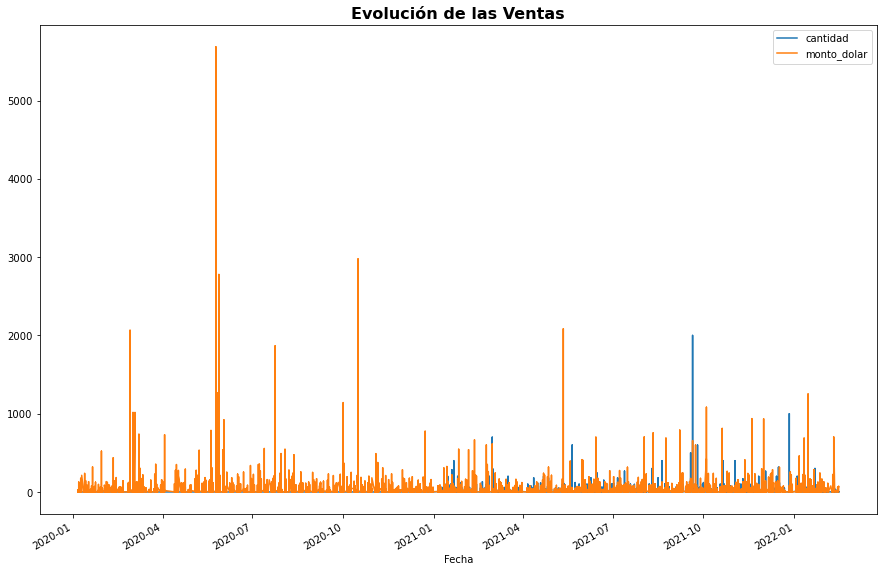

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
df_ventas_fecha.plot(ax=ax)
ax.set_title('Evolución de las Ventas', fontsize=16, weight='bold')
ax.legend()
ax.set_xlabel('Fecha')

/home/diana/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:711: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(*args, **kwds)
/home/diana/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:711: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(*args, **kwds)


Text(0, 0.5, 'N° Facturas')

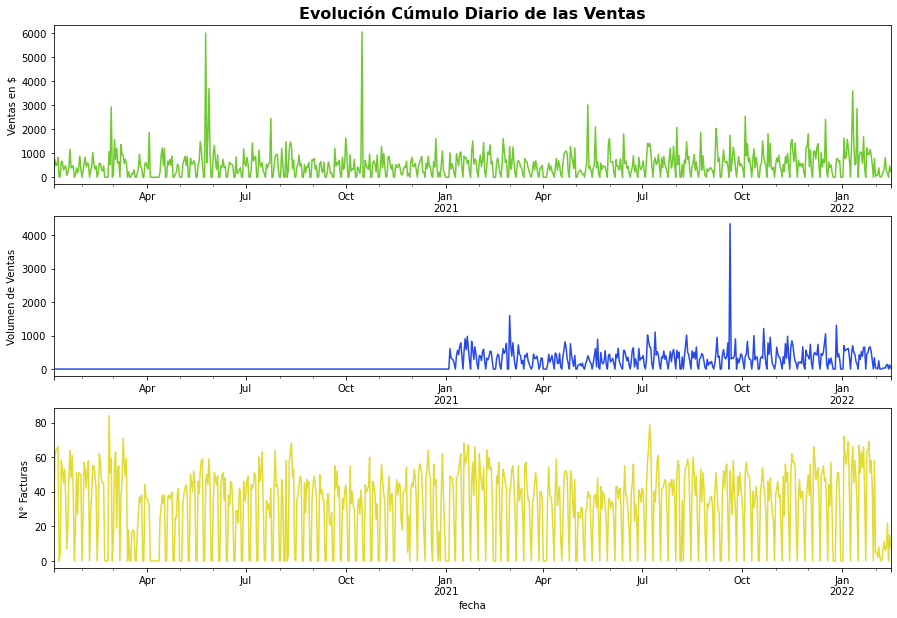

In [23]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15,10))

df_ventas_fecha.monto_dolar.resample('D').sum().plot(ax=ax1, color=MONTO)
df_ventas_fecha.cantidad.resample('D').sum().plot(ax=ax2, COLOR=VOLUMEN)
df_ventas_fecha.num.resample('D').nunique().plot(ax=ax3, COLOR=FACTURAS)
ax1.set_title('Evolución Cúmulo Diario de las Ventas', fontsize=16, weight='bold')
ax1.set_ylabel('Ventas en $')
ax2.set_ylabel('Volumen de Ventas')
ax3.set_ylabel('N° Facturas')

In [24]:
df_ventas_diarias = df_ventas_fecha.monto_dolar.resample('D').sum()
df_ventas_diarias = df_ventas_diarias.reset_index()
df_ventas_diarias.describe()

monto_dolar
count   772.000000
mean    530.097381
std     568.478349
min       0.000000
25%     131.868160
50%     449.317840
75%     720.345567
max    6058.346879

In [25]:
import plotly.graph_objects as go
import plotly.express as px

x = df_ventas_diarias.fecha
y = df_ventas_diarias.monto_dolar
media = df_ventas_diarias.monto_dolar.mean()

fig = px.scatter(df_ventas_diarias, x=x, y=y, 
                 title='Evolución Cúmulo Diario de las Ventas')

fig.add_trace(
    go.Scatter(
        x=[2020, 2022],
        y=[media, media],
        mode="lines",
        line=go.scatter.Line(color="red"),
        text='Media',
        showlegend=True)
)
fig.show()

In [26]:
# Creamos una columna index para poder hacer un gráfico de regresión y ver la tendencia de las ventas

df_ventas_diarias = df_ventas_diarias.reset_index()
df_ventas_diarias

index      fecha  monto_dolar
0        0 2020-01-06   104.610817
1        1 2020-01-07   739.473869
2        2 2020-01-08   485.385935
3        3 2020-01-09   515.495960
4        4 2020-01-10   823.755195
..     ...        ...          ...
767    767 2022-02-11   252.264642
768    768 2022-02-12   176.760259
769    769 2022-02-13     0.000000
770    770 2022-02-14   471.782609
771    771 2022-02-15   247.766885

[772 rows x 3 columns]

Text(0.5, 1.0, 'Evolución de las Ventas en el tiempo y su Tendencia')

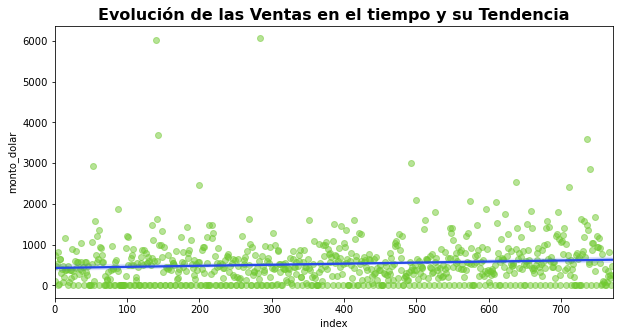

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.regplot(
    x='index',
    y='monto_dolar',
    data=df_ventas_diarias,
    scatter_kws={'color': MONTO, 'alpha': 0.5},
    line_kws={'color': AZUL},
)
ax.set_title(
    'Evolución de las Ventas en el tiempo y su Tendencia',
    fontsize=16,
    weight='bold',
)

Text(0.5, 0, 'Fecha')

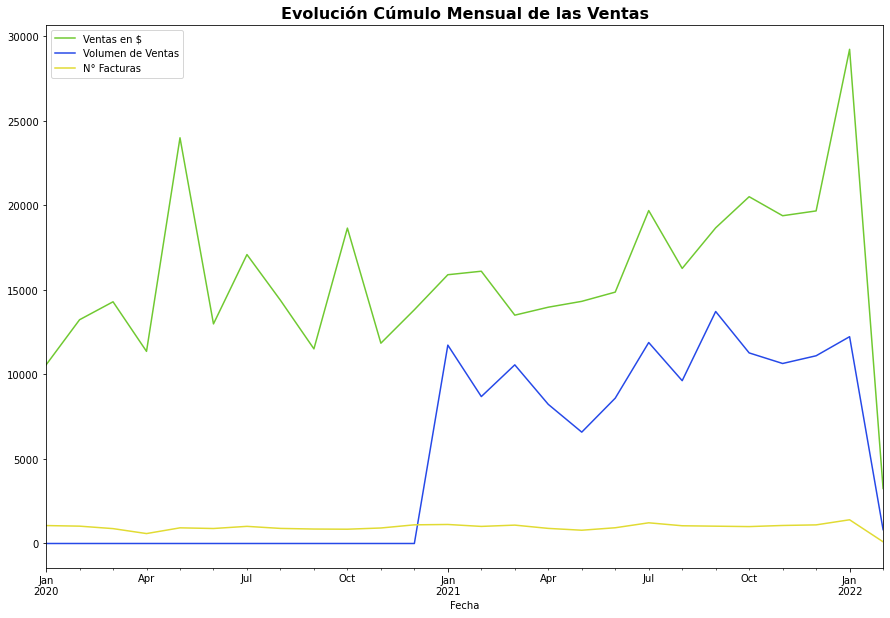

In [28]:
fig, ax = plt.subplots(figsize=(15,10))

df_ventas_fecha.monto_dolar.resample('M').sum().plot(ax=ax, label='Ventas en $', color=MONTO)
df_ventas_fecha.cantidad.resample('M').sum().plot(ax=ax, label='Volumen de Ventas', color=VOLUMEN)
df_ventas_fecha.num.resample('M').nunique().plot(ax=ax, label='N° Facturas', color=FACTURAS)

ax.set_title('Evolución Cúmulo Mensual de las Ventas', fontsize=16, weight='bold')
ax.legend()
ax.set_xlabel('Fecha')

In [29]:
df_ventas_mensuales = df_ventas_fecha.monto_dolar.resample('M').sum()
df_ventas_mensuales = df_ventas_mensuales.reset_index()
df_ventas_mensuales

fecha   monto_dolar
0  2020-01-31  10567.877994
1  2020-02-29  13237.842809
2  2020-03-31  14300.645197
3  2020-04-30  11366.855771
4  2020-05-31  24004.435336
5  2020-06-30  12992.138065
6  2020-07-31  17094.832728
7  2020-08-31  14390.960065
8  2020-09-30  11515.082956
9  2020-10-31  18660.308028
10 2020-11-30  11850.610759
11 2020-12-31  13828.660925
12 2021-01-31  15901.448126
13 2021-02-28  16108.785904
14 2021-03-31  13509.384678
15 2021-04-30  13980.228652
16 2021-05-31  14326.794228
17 2021-06-30  14872.458732
18 2021-07-31  19697.623271
19 2021-08-31  16274.653982
20 2021-09-30  18675.805626
21 2021-10-31  20517.682390
22 2021-11-30  19392.533259
23 2021-12-31  19676.659506
24 2022-01-31  29238.667539
25 2022-02-28   3252.201360

In [30]:
barras = alt.Chart(df_ventas_mensuales).mark_bar().encode(
                x=alt.X('yearmonth(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('yearmonth(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Mes',
                             width=700, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

### Conclusiones:

    1) En promedio de venden 409 productos cada día
    2) El promedio de ventas diario es de 673 dólares
    3) 41 es el promedio de facturas que se hacen diariamente
    4) Se nota un incremento de las ventas a partir del 2do semestre del 2021
    5) Entre marzo y junio de 2021 se resgistraron la menor cantidad de ventas del período estudiado

## Evolución de las Ventas Mes a Mes

### Estudio de las Ventas Excepcionales

Se trata de aquellas ventas cuyo monto es excepcionalmente elevado. 

Buscamos entonces los valores extremos o **outliers**. 

Como se trata de ventas, no los podemos eliminar. Por lo tanto, será necesario aplicar algún tipo de normalización para no tener visualizaciones distorcionadas.

In [31]:
# Queremos identificar las ventas excepcionales, cuyos montos son extremos
# Calculamos el monto total por factura

df_total_factura = df_ventas.groupby('num').monto_dolar.sum()
df_total_factura = df_total_factura.reset_index()
df_total_factura.sort_values('monto_dolar', ascending=False).head(40)


num  monto_dolar
8510   2020-0000004271-fa  5686.278600
10805  2020-0000006335-fa  2977.261000
10806  2020-0000006336-fa  2920.474006
8770   2020-0000004402-fa  2778.282410
23704  2022-0000006399-fa  2280.938776
11002  2021-0000000005-ne  2084.062475
8      2020-0000000005-ne  2065.660461
210    2020-0000000108-ne  1866.830040
20042  2021-0000004549-fa  1435.880431
8638   2020-0000004336-fa  1265.419985
23209  2021-0000006281-fa  1219.543568
10762  2020-0000006292-fa  1141.478936
22985  2021-0000006050-fa  1082.725061
4453   2020-0000002238-fa  1016.637129
4207   2020-0000002115-fa  1015.451327
22260  2021-0000005662-ne   983.036638
23176  2021-0000006247-fa   936.853002
9008   2020-0000004530-fa   923.130116
23000  2021-0000006066-fa   846.770992
20695  2021-0000004877-fa   814.357766
23052  2021-0000006119-fa   811.594203
20752  2021-0000004906-fa   794.944316
15832  2021-0000002433-ne   790.209116
23493  2022-0000006221-ne   787.551020
32     2020-0000000017-ne   785.552448
10974  2020-0000006514-fa   775.696034
14134  2021-0000001582-ne   754.176615
4692   2020-0000002358-fa   737.168986
6074   2020-0000003050-fa   730.313526
15828  2021-0000002431-ne   715.459605
23756  2022-0000006425-ne   705.888337
24045  2022-0000006574-fa   705.098039
13565  2021-0000001297-ne   702.977287
21394  2021-0000005227-fa   700.116772
22507  2021-0000005789-fa   691.227017
14961  2021-0000001996-ne   688.031726
23710  2022-0000006402-fa   687.841191
14942  2021-0000001987-fa   683.633177
14198  2021-0000001615-fa   665.438186
16591  2021-0000002815-ne   655.904317

In [32]:
df_total_factura.describe()

monto_dolar
count  24794.000000
mean      16.505412
std       71.877774
min        0.000317
25%        1.904330
50%        4.932434
75%       12.615886
max     5686.278600

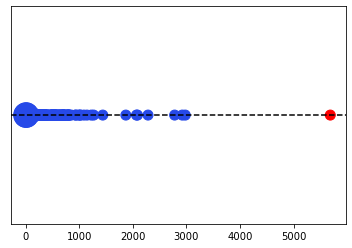

In [33]:
montos = np.array(df_total_factura.monto_dolar)
montos_unicos, counts = np.unique(montos, return_counts=True)
 
sizes = counts*100
colores = [AZUL]*len(montos_unicos)
colores[-1] = 'red'
 
plt.axhline(1, color='k', linestyle='--')
plt.scatter(montos_unicos, np.ones(len(montos_unicos)), s=sizes, color=colores)
plt.yticks([])
plt.show()

<AxesSubplot:xlabel='monto_dolar', ylabel='Density'>

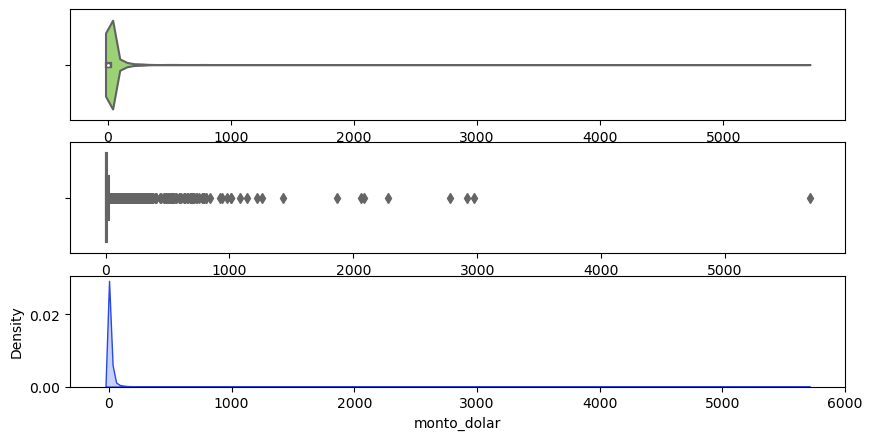

In [34]:
# Definición de los colores para los gráficos


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='monto_dolar', data=df_total_factura, color=VERDE, ax=ax1)
sns.boxplot(x='monto_dolar', data=df_total_factura, color=AMARILLO, ax=ax2)
sns.kdeplot(x='monto_dolar', data=df_total_factura, color=AZUL, shade=True, ax=ax3)

In [35]:
df_total_factura_max = df_total_factura.query('monto_dolar > 1000.0')
df_total_factura_max.describe()

monto_dolar
count    15.000000
mean   2055.794947
std    1225.904000
min    1015.451327
25%    1180.511252
50%    1866.830040
75%    2529.610593
max    5686.278600

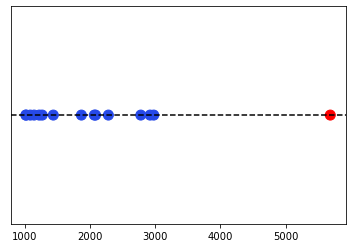

In [36]:
montos = np.array(df_total_factura_max.monto_dolar)
montos_unicos, counts = np.unique(montos, return_counts=True)
 
sizes = counts*100
colores = [AZUL]*len(montos_unicos)
colores[-1] = 'red'
 
plt.axhline(1, color='k', linestyle='--')
plt.scatter(montos_unicos, np.ones(len(montos_unicos)), s=sizes, color=colores)
plt.yticks([])
plt.show()

<AxesSubplot:xlabel='monto_dolar', ylabel='Density'>

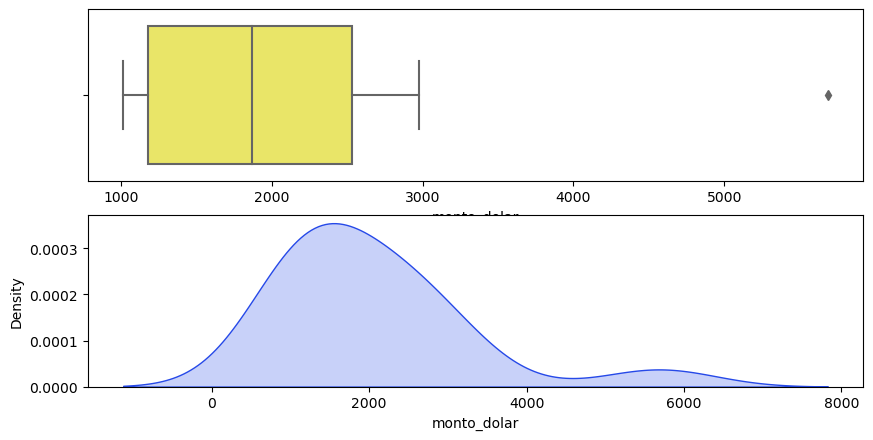

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(10,5))

sns.boxplot(x='monto_dolar', data=df_total_factura_max, color=AMARILLO, ax=ax1)
sns.kdeplot(x='monto_dolar', data=df_total_factura_max, color=AZUL, shade=True, ax=ax2)

### Conclusiones

1. La gran mayoría de las ventas no sobrepasa los 100 USD
2. Se observa un grupo que va hasta los 1.000 USD, luego dos pequeños grupos al rededor de los 2.000 USD y 3.000 USD
3. Hay un caso extremo que sobrepasa lod 5.680 USD
4. Hay apenas 15 ventas con montos mayores a 1.000 USD, lo que equivale a 0,06% de las ventas. Haremos comparaciones entre los datos completos y los datos sin las ventas mayores a 1.000 USD

## Tráfico de Clientes

Usamos el número de facturas por día de la semana para determinar los días en que hay mayor cantidad de clientes

In [38]:
# Utilizamos nunique para contabilizar sólo una vez cada referencia de factura

df_n_fact = df_ventas.loc[:,['fecha_comp', 'fecha', 'num']]

df_n_fact['mes'] = df_n_fact.fecha_comp.dt.month
df_n_fact['año'] = df_n_fact.fecha_comp.dt.year

df_n_fact['dia_semana'] = df_n_fact.fecha_comp.dt.weekday
df_n_fact['dia_mes'] = df_n_fact.fecha_comp.dt.day

df_n_fact['hora'] = df_n_fact.fecha_comp.dt.hour

df_n_fact.sample(25)

fecha_comp      fecha                 num  mes   año  \
40823 2022-02-04 07:53:00 2022-02-04  2022-0000006490-fa    2  2022   
36486 2021-11-22 15:37:00 2021-11-22  2021-0000004749-ne   11  2021   
13546 2022-01-11 09:28:00 2022-01-11  2022-0000006399-ne    1  2022   
39357 2021-08-23 10:52:00 2021-08-23  2021-0000001971-ne    8  2021   
13434 2022-01-05 10:24:00 2022-01-05  2022-0000006152-ne    1  2022   
5519  2020-11-26 16:15:00 2020-11-26  2020-0000003394-ne   11  2020   
3505  2020-09-11 14:28:00 2020-09-11  2020-0000001469-ne    9  2020   
37652 2021-08-11 11:14:00 2021-08-11  2021-0000001574-ne    8  2021   
31904 2021-10-21 12:00:00 2021-10-21  2021-0000006128-fa   10  2021   
33163 2021-12-06 15:56:00 2021-12-06  2021-0000005202-ne   12  2021   
2945  2020-10-05 10:35:00 2020-10-05  2020-0000001948-ne   10  2020   
12774 2022-01-22 08:14:00 2022-01-22  2022-0000006892-ne    1  2022   
26164 2021-01-11 13:43:00 2021-01-11  2021-0000000232-fa    1  2021   
11947 2022-01-10 11:38:00 2022-01-10  2022-0000006362-ne    1  2022   
23631 2021-01-22 14:36:00 2021-01-22  2021-0000000808-fa    1  2021   
23841 2021-02-04 11:07:00 2021-02-04  2021-0000001309-fa    2  2021   
2403  2020-08-12 16:01:00 2020-08-12  2020-0000000653-ne    8  2020   
31641 2021-08-31 08:31:00 2021-08-31  2021-0000002195-ne    8  2021   
5198  2020-11-16 17:09:00 2020-11-16  2020-0000003054-ne   11  2020   
21548 2021-01-18 09:22:00 2021-01-18  2021-0000000509-fa    1  2021   
7224  2020-01-20 16:52:00 2020-01-20  2020-0000000598-fa    1  2020   
40315 2021-11-08 14:10:00 2021-11-08  2021-0000004256-ne   11  2021   
38351 2021-12-03 10:35:00 2021-12-03  2021-0000006291-fa   12  2021   
9410  2020-04-02 08:58:00 2020-04-02  2020-0000003006-fa    4  2020   
339   2020-04-30 10:04:00 2020-04-30  2020-0000003527-fa    4  2020   

       dia_semana  dia_mes  hora  
40823           4        4     7  
36486           0       22    15  
13546           1       11     9  
39357           0       23    10  
13434           2        5    10  
5519            3       26    16  
3505            4       11    14  
37652           2       11    11  
31904           3       21    12  
33163           0        6    15  
2945            0        5    10  
12774           5       22     8  
26164           0       11    13  
11947           0       10    11  
23631           4       22    14  
23841           3        4    11  
2403            2       12    16  
31641           1       31     8  
5198            0       16    17  
21548           0       18     9  
7224            0       20    16  
40315           0        8    14  
38351           4        3    10  
9410            3        2     8  
339             3       30    10

In [39]:
df_cl_fecha_semana = df_n_fact.query('dia_semana < 5').groupby('fecha').num.nunique()
df_cl_fecha_semana.describe()

count    529.000000
mean      43.776938
std       12.148207
min        1.000000
25%       37.000000
50%       44.000000
75%       52.000000
max       84.000000
Name: num, dtype: float64

In [40]:
df_cl_fecha_we = df_n_fact.query('dia_semana == 5').groupby('fecha').num.nunique()
df_cl_fecha_we.describe()

count    61.000000
mean     23.491803
std       9.592745
min       1.000000
25%      18.000000
50%      24.000000
75%      30.000000
max      42.000000
Name: num, dtype: float64

In [41]:
df_cl_dias = df_n_fact.pivot_table('num', index='dia_semana', aggfunc={'num':'nunique' }) 
df_cl_dias = df_cl_dias.reset_index()
df_cl_dias

dia_semana   num
0           0  4574
1           1  4783
2           2  4765
3           3  4607
4           4  4429
5           5  1433
6           6   205

<AxesSubplot:xlabel='dia_semana', ylabel='num'>

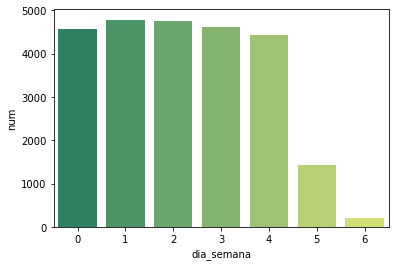

In [42]:
sns.barplot(data=df_cl_dias, x='dia_semana', y='num', palette='summer')

In [43]:
df_cl_hora = df_n_fact.pivot_table('num', index='hora', aggfunc={'num':'nunique' }) 
df_cl_hora = df_cl_hora.reset_index()
df_cl_hora

hora   num
0      0   190
1      1    10
2      2     7
3      3     5
4      4    11
5      5    10
6      6    15
7      7    70
8      8  2311
9      9  3859
10    10  4994
11    11  4965
12    12   713
13    13   445
14    14  2954
15    15  2524
16    16  1575
17    17    82
18    18     3
19    19     9
20    20     6
21    21     4
22    22    11
23    23    23

<AxesSubplot:xlabel='hora', ylabel='num'>

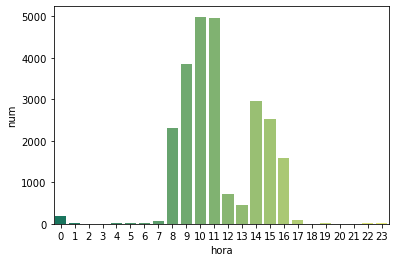

In [44]:
sns.barplot(data=df_cl_hora, x='hora', y='num', palette='summer')

In [45]:
# Sin los fines de semana

df_cl_hora_sin_we = df_n_fact.query('dia_semana < 5')

df_cl_hora_sin_we = df_cl_hora_sin_we.pivot_table('num', index='hora', aggfunc={'num':'nunique' }) 
df_cl_hora_sin_we = df_cl_hora_sin_we.reset_index()
df_cl_hora_sin_we

hora   num
0      0   180
1      1    10
2      2     7
3      3     5
4      4    11
5      5     6
6      6     4
7      7    64
8      8  2096
9      9  3519
10    10  4525
11    11  4448
12    12   668
13    13   445
14    14  2952
15    15  2521
16    16  1575
17    17    82
18    18     3
19    19     9
20    20     5
21    21     2
22    22     2
23    23    19

<AxesSubplot:xlabel='hora', ylabel='num'>

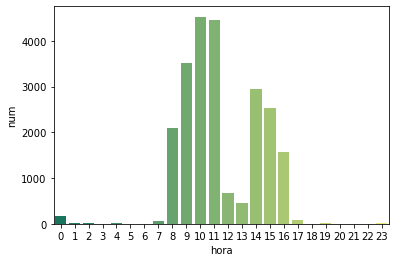

In [46]:
sns.barplot(data=df_cl_hora_sin_we, x='hora', y='num', palette='summer')

### Conclusiones:

1. En promedio, se hacen 41 ventas al día (número de facturas): 43 en días de semana y 23 los fines de semana. Aproximadamente 6 facturas por hora (43 / 7 por las 7 horas que abre la tienda cada día)
2. Martes y miércoles son los días de mayor afluencia de clientes, seguido del lunes
3. A partir del jueves, la afluencia disminuye, en particular el fin de semana
4. Las horas de mayor afluencia es entre las 10am y las 12pm, y en la tarde de 2pm a 3pm

**Es recomendable garantizar la presencia y disponibilidad de todo el personal los lunes, martes y miércoles y en particular todos los días de 10am a 12pm**

## Estudio de las ventas con Altair

In [47]:
# Utilizamos nunique para contabilizar sólo una vez cada referencia de factura
df_ventas_ag = df_ventas.pivot_table(index='fecha', values=['num', 'cantidad', 'monto_dolar'], 
                                        aggfunc={'num':'nunique', 'cantidad':sum, 'monto_dolar':sum })
df_ventas_ag = df_ventas_ag.reset_index()
df_ventas_ag

fecha  cantidad  monto_dolar  num
0   2020-01-06      0.00   104.610817   21
1   2020-01-07      0.00   739.473869   59
2   2020-01-08      0.00   485.385935   64
3   2020-01-09      0.00   515.495960   65
4   2020-01-10      0.00   823.755195   66
..         ...       ...          ...  ...
597 2022-02-10     31.00   816.187364    6
598 2022-02-11    111.00   252.264642    8
599 2022-02-12    139.90   176.760259   22
600 2022-02-14    126.10   471.782609   15
601 2022-02-15     29.25   247.766885    8

[602 rows x 4 columns]

In [48]:
# Utilizamos nunique para contabilizar sólo una vez cada referencia de factura
df_ventas_ag_sin_ext = df_ventas.query('monto_dolar <= 1000')
df_ventas_ag_sin_ext 

num          fecha_comp     cliente  vendedor  \
0      2020-0000000001-ne 2020-01-07 11:04:00  18018450.0        13   
1      2020-0000000022-fa 2020-01-07 08:57:00  10747595.0        11   
2      2020-0000000023-fa 2020-01-07 07:52:00  14281493.0         7   
3      2020-0000000024-fa 2020-01-07 09:25:00  19339734.0         7   
4      2020-0000000025-fa 2020-01-07 09:20:00  16788717.0        13   
...                   ...                 ...         ...       ...   
40916  2022-0000006497-fa 2022-02-05 11:55:00  13763788.0        13   
40917  2022-0000006497-fa 2022-02-05 11:55:00  13763788.0        13   
40918  2022-0000006497-fa 2022-02-05 11:55:00  13763788.0        13   
40919  2022-0000006498-fa 2022-02-05 11:58:00  10743720.0         1   
40920  2022-0000006499-fa 2022-02-07 09:48:00   9339434.0        11   

            monto tipo    cod  \
0       170601.20   ne          
1      1377605.59   fa          
2       623407.20   fa          
3      8520323.59   fa          
4       490901.59   fa          
...           ...  ...    ...   
40916        1.19   fa  00809   
40917        1.66   fa  01398   
40918        6.90   fa  01404   
40919       69.75   fa  04072   
40920      356.00   fa  05329   

                                                producto  cantidad      fecha  \
0                                                              0.0 2020-01-07   
1                                                              0.0 2020-01-07   
2                                                              0.0 2020-01-07   
3                                                              0.0 2020-01-07   
4                                                              0.0 2020-01-07   
...                                                  ...       ...        ...   
40916                          CONFITERIA TORONTO  SAVOY       1.0 2022-02-05   
40917           CONFITERIA PASTILLAS CHAO SANDIA/ CEREZA       1.0 2022-02-05   
40918                             CONFITERIA OREO TUBITO       1.0 2022-02-05   
40919               CERRADURA MANILLA RECTA ALUMINIO TOC       1.0 2022-02-05   
40920  GRIFERIA LAVAPLATOS EXTRAIBLE CURVA CAL 41*22C...       1.0 2022-02-07   

       tasa_dolar  monto_dolar  
0        67581.00     2.524396  
1        67581.00    20.384510  
2        67581.00     9.224593  
3        67581.00   126.075725  
4        67581.00     7.263899  
...           ...          ...  
40916        4.60     0.258696  
40917        4.60     0.360870  
40918        4.60     1.500000  
40919        4.60    15.163043  
40920        4.61    77.223427  

[40908 rows x 12 columns]

In [49]:
df_ventas_ag_sin_ext = df_ventas_ag_sin_ext.pivot_table(index='fecha', values=['num', 'cantidad', 'monto_dolar'], 
                                        aggfunc={'num':'nunique', 'cantidad':sum, 'monto_dolar':sum })

df_ventas_ag_sin_ext = df_ventas_ag_sin_ext.reset_index()
df_ventas_ag_sin_ext

fecha  cantidad  monto_dolar  num
0   2020-01-06      0.00   104.610817   21
1   2020-01-07      0.00   739.473869   59
2   2020-01-08      0.00   485.385935   64
3   2020-01-09      0.00   515.495960   65
4   2020-01-10      0.00   823.755195   66
..         ...       ...          ...  ...
597 2022-02-10     31.00   816.187364    6
598 2022-02-11    111.00   252.264642    8
599 2022-02-12    139.90   176.760259   22
600 2022-02-14    126.10   471.782609   15
601 2022-02-15     29.25   247.766885    8

[602 rows x 4 columns]

In [50]:
df_ventas_ag.describe()

cantidad  monto_dolar         num
count   602.000000   602.000000  602.000000
mean    225.507824   679.792654   41.189369
std     314.579057   559.149689   13.791918
min       0.000000     7.996093    1.000000
25%       0.000000   383.090619   34.000000
50%     126.935000   559.839711   42.000000
75%     385.750000   836.492378   51.000000
max    4350.000000  6058.346879   84.000000

In [51]:
df_ventas_mes = df_ventas_ag
df_ventas_mes['mes_anio'] = df_ventas_mes.fecha.dt.strftime('%m-%Y')
df_ventas_mes['dia_semana'] = df_ventas_mes.fecha.dt.weekday
df_ventas_mes['dia_mes'] = df_ventas_mes.fecha.dt.day
df_ventas_mes.set_index('fecha', inplace=True)
df_ventas_mes

cantidad  monto_dolar  num mes_anio  dia_semana  dia_mes
fecha                                                               
2020-01-06      0.00   104.610817   21  01-2020           0        6
2020-01-07      0.00   739.473869   59  01-2020           1        7
2020-01-08      0.00   485.385935   64  01-2020           2        8
2020-01-09      0.00   515.495960   65  01-2020           3        9
2020-01-10      0.00   823.755195   66  01-2020           4       10
...              ...          ...  ...      ...         ...      ...
2022-02-10     31.00   816.187364    6  02-2022           3       10
2022-02-11    111.00   252.264642    8  02-2022           4       11
2022-02-12    139.90   176.760259   22  02-2022           5       12
2022-02-14    126.10   471.782609   15  02-2022           0       14
2022-02-15     29.25   247.766885    8  02-2022           1       15

[602 rows x 6 columns]

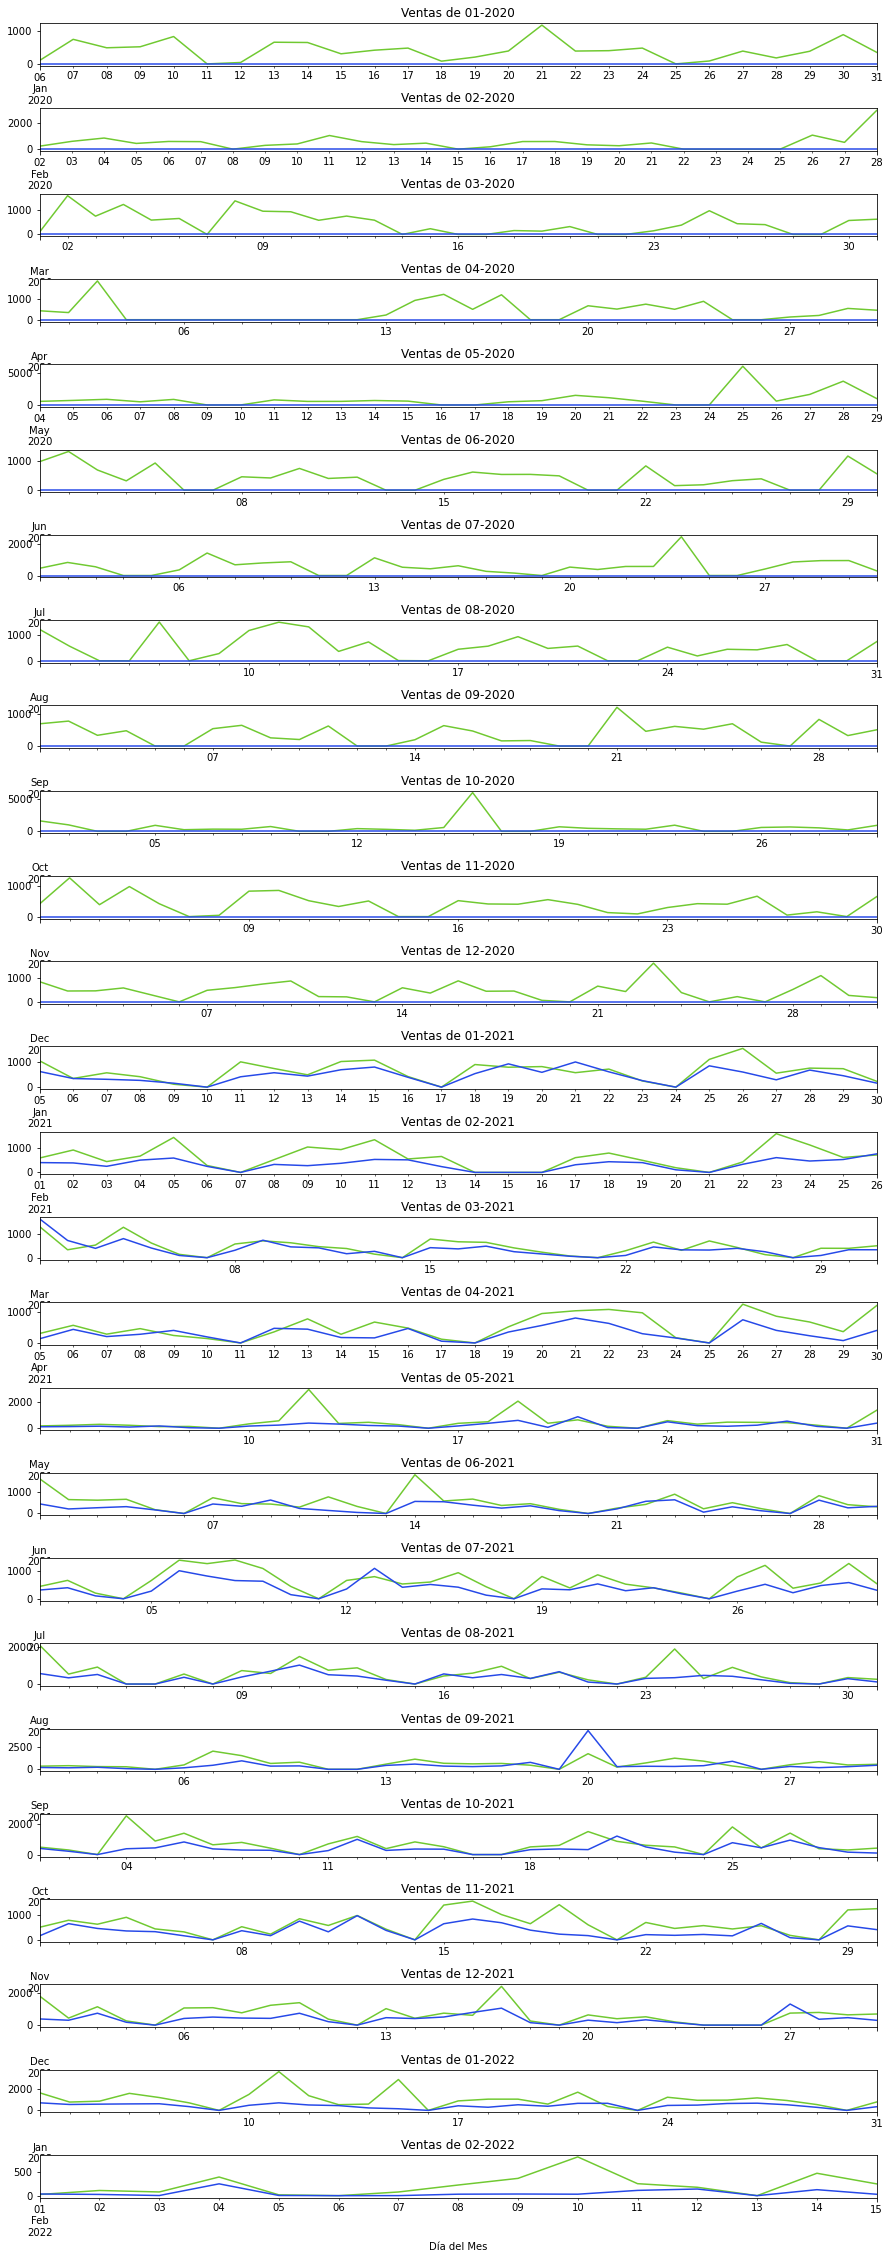

In [52]:
# Variación de las ventas diarias mes por mes
n_graf = len(df_ventas_mes.mes_anio.unique())

fig, ax = plt.subplots(n_graf, 1, figsize=(15,40))

i=0

for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.monto_dolar.resample('D').sum().plot(ax=ax[i], label='Ventas en $', color=MONTO)
    df_graf.cantidad.resample('D').sum().plot(ax=ax[i], label='Volumen de Ventas', color=VOLUMEN)

    ax[i].set(title = f"Ventas de {mes_anio}")
    ax[i].set_xlabel('Día del Mes')
    ax[i]
    
    i=i+1
    
fig.subplots_adjust(hspace=1)

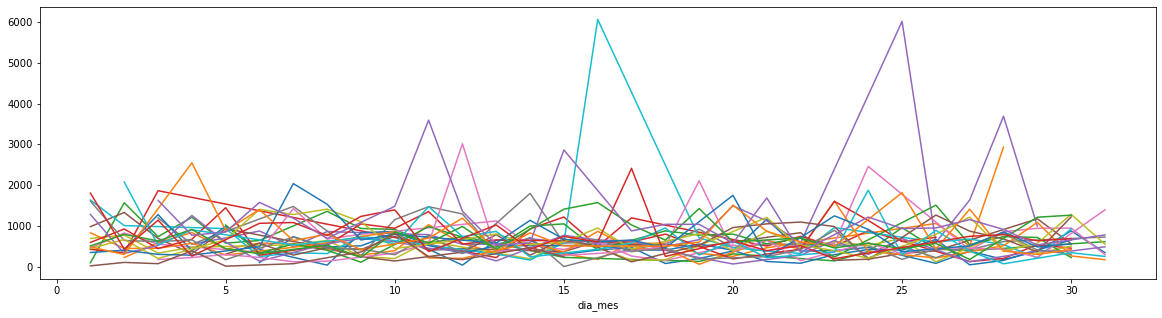

In [53]:
# Variación de las ventas diarias mes por mes
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_mes').monto_dolar.sum().plot(figsize=(20,5))
    

Text(0.5, 0.95, 'Ventas en $ por Día del Mes')

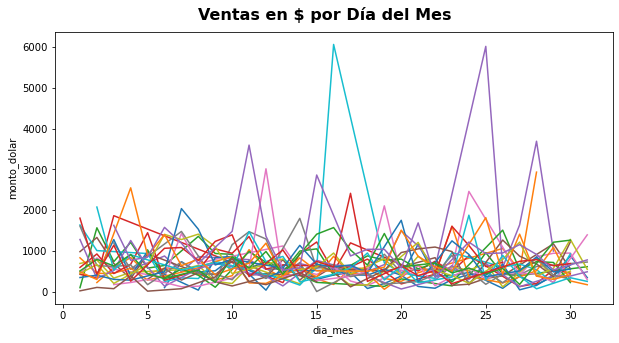

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf = df_graf.groupby('dia_mes').monto_dolar.sum()
    
    sns.lineplot(
        data=df_graf,
        ax=ax,
        #line_kws={"color": "g"},
    )
fig.suptitle(
    'Ventas en $ por Día del Mes',
    fontsize=16,
    weight="bold",
    y=0.95,
)

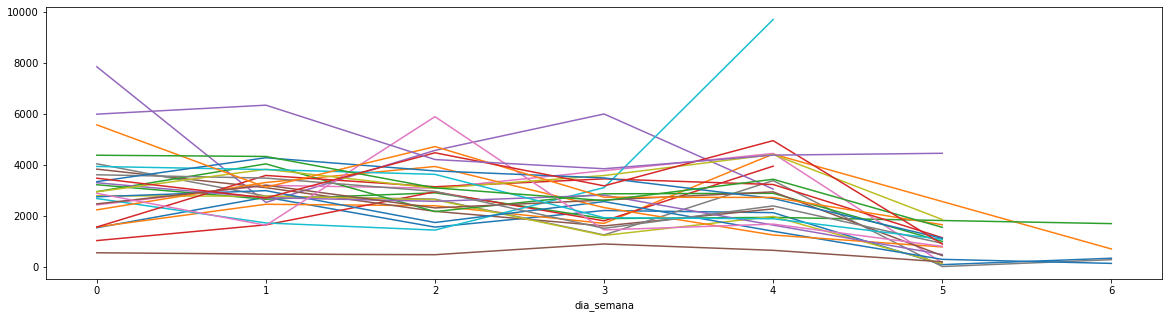

In [55]:
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_semana').monto_dolar.sum().plot(figsize=(20,5))

Los lunes y martes son los días en los que más se vende en $. El viernes en Volumen

Los jueves son los días que menos se vende, que sea en volumen o en $

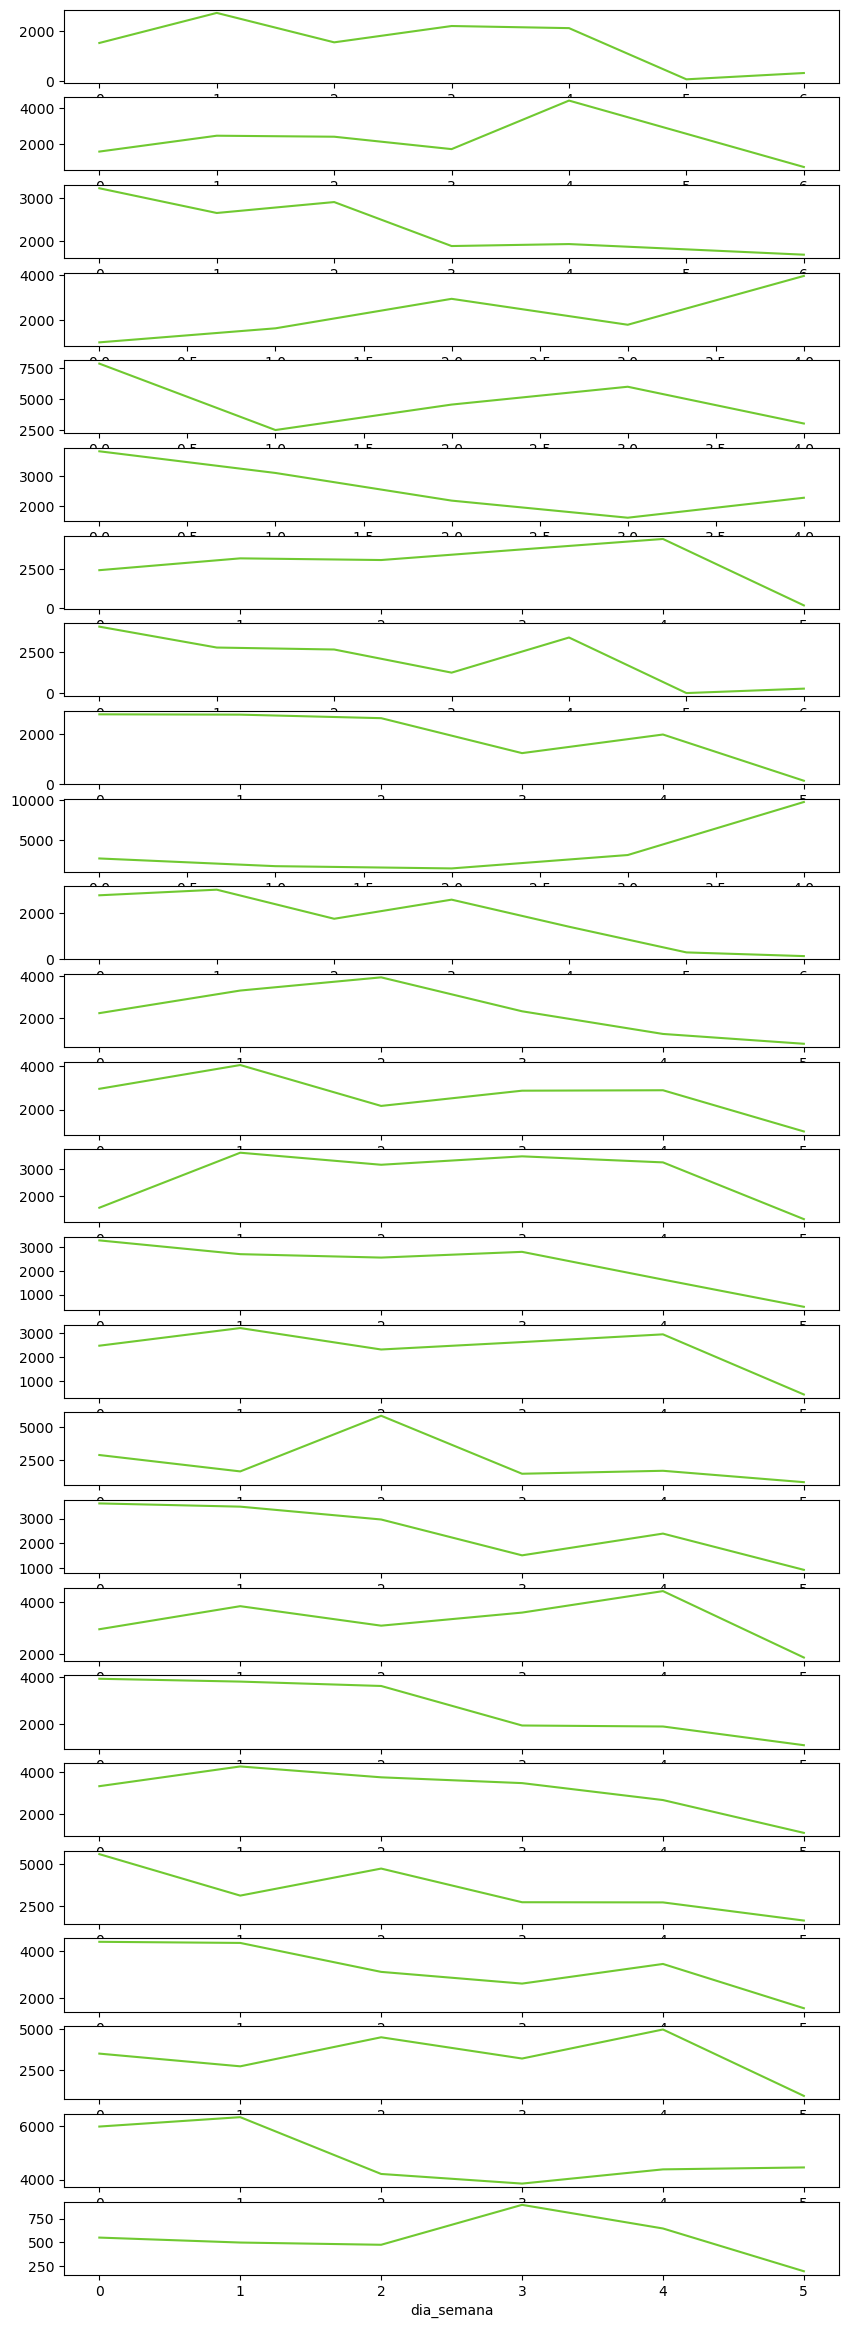

In [56]:
n_graf = len(df_ventas_mes.mes_anio.unique())

fig, ax = plt.subplots(n_graf, 1, dpi=100, figsize=(10,30))

i=0
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_semana').monto_dolar.sum().plot(ax=ax[i], color=MONTO)
    i=i+1

In [57]:
df_ventas_ag.reset_index(inplace=True)
df_ventas_ag
df_ventas_ag['año'] = df_ventas_ag.fecha.dt.year
df_ventas_ag['mes_año'] = df_ventas_ag.fecha.dt.strftime('%m-%Y')
df_ventas_ag['dia_semana'] = df_ventas_ag.fecha.dt.weekday
df_ventas_ag['dia_mes'] = df_ventas_ag.fecha.dt.day
df_ventas_ag

fecha  cantidad  monto_dolar  num mes_anio  dia_semana  dia_mes  \
0   2020-01-06      0.00   104.610817   21  01-2020           0        6   
1   2020-01-07      0.00   739.473869   59  01-2020           1        7   
2   2020-01-08      0.00   485.385935   64  01-2020           2        8   
3   2020-01-09      0.00   515.495960   65  01-2020           3        9   
4   2020-01-10      0.00   823.755195   66  01-2020           4       10   
..         ...       ...          ...  ...      ...         ...      ...   
597 2022-02-10     31.00   816.187364    6  02-2022           3       10   
598 2022-02-11    111.00   252.264642    8  02-2022           4       11   
599 2022-02-12    139.90   176.760259   22  02-2022           5       12   
600 2022-02-14    126.10   471.782609   15  02-2022           0       14   
601 2022-02-15     29.25   247.766885    8  02-2022           1       15   

      año  mes_año  
0    2020  01-2020  
1    2020  01-2020  
2    2020  01-2020  
3    2020  01-2020  
4    2020  01-2020  
..    ...      ...  
597  2022  02-2022  
598  2022  02-2022  
599  2022  02-2022  
600  2022  02-2022  
601  2022  02-2022  

[602 rows x 9 columns]

In [58]:
lineas = alt.Chart(df_ventas_ag).mark_line().encode(
    x='fecha:T',
    y='monto_dolar:Q',
    color=alt.Color('yearmonth(fecha):T', scale=alt.Scale(scheme='goldgreen')),
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('monto_dolar:Q', title='Ventas en $')
    ]).properties(width=800, height=200)

lineas

alt.Chart(...)

In [59]:
lineas = alt.Chart(df_ventas_ag).mark_line().encode(
    x='fecha:T',
    y='cantidad:Q',
    color=alt.Color('yearmonth(fecha):T', scale=alt.Scale(scheme='purpleblue')),
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('cantidad:Q', title='Volumen de Venta')
    ]).properties(width=800, height=200)

lineas

alt.Chart(...)

In [60]:
lineas = alt.Chart(df_ventas_ag).mark_line().encode(
    x='fecha:T',
    y='num:Q',
    color=alt.Color('yearmonth(fecha):O', scale=alt.Scale(scheme='goldorange')),
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('num:Q', title='N° Facturas')
    ]).properties(width=800, height=200)

lineas

alt.Chart(...)

In [61]:
df_ventas_dia_semana = df_ventas_ag.pivot_table(index=df_ventas_ag.fecha.dt.strftime('%m-%Y'),
                                            columns=df_ventas_ag.fecha.dt.weekday, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_semana 

monto_dolar                                                      \
fecha              0            1            2            3            4   
fecha                                                                      
01-2020  1531.657232  2730.974894  1557.202647  2207.919301  2123.907868   
01-2021  2950.556683  4039.964339  2166.060704  2864.239439  2884.332234   
01-2022  5993.008193  6345.862615  4211.000312  3849.191008  4383.430025   
02-2020  1563.447720  2453.311830  2397.020698  1701.697084  4424.442111   
02-2021  1559.886233  3585.569561  3141.892730  3451.844984  3229.538314   
02-2022   549.006036   496.764451   473.216378   894.183072   644.988555   
03-2020  3220.645464  2652.192226  2903.512438  1892.565451  1937.839969   
03-2021  3298.064658  2713.807813  2568.880136  2812.007238  1635.795558   
04-2020  1027.444224  1645.236462  2942.525720  1801.916525  3949.732841   
04-2021  2468.683163  3202.946005  2310.648747  2619.331624  2941.064728   
05-2020  7854.959273  2528.419154  4570.174850  5999.999829  3050.882230   
05-2021  2883.251353  1626.363609  5894.606022  1447.094554  1673.973381   
06-2020  3833.685642  3105.616794  2177.094470  1602.669703  2273.071456   
06-2021  3612.375030  3481.414043  2961.057943  1507.987450  2389.329167   
07-2020  2431.498008  3196.185788  3088.079515  3774.515277  4449.881610   
07-2021  2942.644847  3828.785077  3079.710761  3582.390103  4408.330709   
08-2020  4043.862722  2774.204571  2655.105064  1249.315214  3383.577080   
08-2021  3938.888904  3817.415182  3628.801368  1926.945845  1883.957056   
09-2020  2785.093720  2772.080027  2630.947624  1229.478122  1975.287385   
09-2021  3341.969818  4281.933775  3764.275245  3488.371117  2681.302988   
10-2020  2679.719593  1720.262033  1439.657625  3107.864567  9712.804210   
10-2021  5572.556618  3122.798839  4719.426861  2731.650867  2721.634103   
11-2020  2747.359079  2988.822244  1737.501192  2559.723768  1395.196235   
11-2021  4379.532099  4331.640255  3098.016685  2598.875623  3435.663573   
12-2020  2234.683248  3309.964875  3937.292916  2323.513895  1245.458278   
12-2021  3477.849793  2700.962950  4476.155053  3176.981472  4952.909467   

                                   
fecha              5            6  
fecha                              
01-2020    82.358816   333.857234  
01-2021   996.294727     0.000000  
01-2022  4456.175386     0.000000  
02-2020     0.000000   697.923364  
02-2021  1140.054082     0.000000  
02-2022   194.042868     0.000000  
03-2020     0.000000  1693.889650  
03-2021   480.829274     0.000000  
04-2020     0.000000     0.000000  
04-2021   437.554386     0.000000  
05-2020     0.000000     0.000000  
05-2021   801.505309     0.000000  
06-2020     0.000000     0.000000  
06-2021   920.295099     0.000000  
07-2020   154.672530     0.000000  
07-2021  1855.761776     0.000000  
08-2020     7.996093   276.899321  
08-2021  1078.645626     0.000000  
09-2020   122.196078     0.000000  
09-2021  1117.952683     0.000000  
10-2020     0.000000     0.000000  
10-2021  1649.615102     0.000000  
11-2020   290.431152   131.577089  
11-2021  1548.805023     0.000000  
12-2020   777.747714     0.000000  
12-2021   891.800771     0.000000

In [62]:
mapa = alt.Chart(df_ventas_ag).mark_rect().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color('sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=300, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [63]:
mapa = alt.Chart(df_ventas_ag_sin_ext).mark_rect().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color('sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=300, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [64]:
barras = alt.Chart(df_ventas_ag).mark_bar().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=600, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

In [65]:
barras = alt.Chart(df_ventas_ag_sin_ext).mark_bar().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=600, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

In [66]:
df_ventas_ag['mes'] = df_ventas_ag.fecha.dt.month
df_ventas_ag

fecha  cantidad  monto_dolar  num mes_anio  dia_semana  dia_mes  \
0   2020-01-06      0.00   104.610817   21  01-2020           0        6   
1   2020-01-07      0.00   739.473869   59  01-2020           1        7   
2   2020-01-08      0.00   485.385935   64  01-2020           2        8   
3   2020-01-09      0.00   515.495960   65  01-2020           3        9   
4   2020-01-10      0.00   823.755195   66  01-2020           4       10   
..         ...       ...          ...  ...      ...         ...      ...   
597 2022-02-10     31.00   816.187364    6  02-2022           3       10   
598 2022-02-11    111.00   252.264642    8  02-2022           4       11   
599 2022-02-12    139.90   176.760259   22  02-2022           5       12   
600 2022-02-14    126.10   471.782609   15  02-2022           0       14   
601 2022-02-15     29.25   247.766885    8  02-2022           1       15   

      año  mes_año  mes  
0    2020  01-2020    1  
1    2020  01-2020    1  
2    2020  01-2020    1  
3    2020  01-2020    1  
4    2020  01-2020    1  
..    ...      ...  ...  
597  2022  02-2022    2  
598  2022  02-2022    2  
599  2022  02-2022    2  
600  2022  02-2022    2  
601  2022  02-2022    2  

[602 rows x 10 columns]

In [67]:
lineas = alt.Chart(df_ventas_ag).mark_line().encode(
    x='dia_mes:O',
    y='monto_dolar:Q',
    color=alt.Color('año:N', scale=alt.Scale(domain=AÑOS, range=COLORES)),
    column=alt.Column('month(fecha):T', title='yearmonth(fecha)'),
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('monto_dolar:Q', title='Ventas en $'),
    ]).properties(width=800, height=200)

lineas

alt.Chart(...)

### Análisis por mes

In [68]:
df_ventas_dia_mes = df_ventas_ag.pivot_table(index=df_ventas_ag.fecha.dt.strftime('%m-%Y'),
                                            columns=df_ventas_ag.fecha.dt.day, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_mes

monto_dolar                                                      \
fecha             1            2            3            4            5    
fecha                                                                      
01-2020     0.000000     0.000000     0.000000     0.000000     0.000000   
01-2021     0.000000     0.000000     0.000000     0.000000  1025.174371   
01-2022     0.000000     0.000000  1628.923241   773.260504   854.500000   
02-2020     0.000000   228.427405   591.898212   840.911939   434.875294   
02-2021   597.742987   928.112308   448.788414   676.658349  1448.390864   
02-2022    24.791045   109.068230    77.995708   392.723913    17.282609   
03-2020   102.471183  1569.100584   740.156960  1213.586690   581.002611   
03-2021  1282.797023   327.117997   521.856075  1258.638821   606.867712   
04-2020   429.947573   343.727378  1865.040038     0.000000     0.000000   
04-2021     0.000000     0.000000     0.000000     0.000000   310.550924   
05-2020     0.000000     0.000000     0.000000   559.629421   708.440722   
05-2021     0.000000     0.000000   179.121985   229.004501   303.164561   
06-2020   984.311972  1332.024144   696.307495   323.136042   935.775980   
06-2021  1610.459773   645.720572   618.434072   660.443987   176.276599   
07-2020   460.703161   830.441806   554.543131     0.000000     0.000000   
07-2021   449.820795   670.552823   205.902734     0.000000   665.648431   
08-2020     0.000000     0.000000  1197.170954   556.828608     0.000000   
08-2021     0.000000  2076.398369   532.983106   908.458977     0.000000   
09-2020   696.059023   780.140801   336.050436   478.429830     0.000000   
09-2021   351.150160   407.752358   306.196339   286.529001     0.000000   
10-2020  1637.070887  1010.448421     0.000000     0.000000   938.159789   
10-2021   489.654244   302.497817     0.000000  2547.654501   889.681818   
11-2020     0.000000   421.493914  1279.945126   393.706990   992.169576   
11-2021   511.719101   795.961538   634.821670   915.937639   444.185268   
12-2020   834.225726   450.752098   456.728855   577.661259   289.318192   
12-2021  1804.950207   437.373695  1142.676471   262.088050     0.000000   

                                                                          ...  \
fecha             6            7            8            9            10  ...   
fecha                                                                     ...   
01-2020   104.610817   739.473869   485.385935   515.495960   823.755195  ...   
01-2021   338.556452   559.099981   406.877705   113.560197     0.000000  ...   
01-2022  1579.416327  1191.730392   698.201474     0.000000  1482.000000  ...   
02-2020   582.694724   568.515668     0.000000   288.046326   395.750196  ...   
02-2021   285.706649     0.000000   528.333392  1052.128996   945.011517  ...   
02-2022     0.000000    77.223427   224.206522   364.148148   816.187364  ...   
03-2020   646.227529     0.000000  1359.571616   940.063855   918.230849  ...   
03-2021   138.317334     0.000000   566.644612   696.262891   616.013044  ...   
04-2020     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
04-2021   577.616637   288.305906   468.976941   244.816049   144.322024  ...   
05-2020   878.469839   492.796971   864.247780     0.000000     0.000000  ...   
05-2021   229.910797   125.169426   138.451233     0.000000   337.713740  ...   
06-2020     0.000000     0.000000   462.697836   422.152875   749.672755  ...   
06-2021     0.000000   732.745323   457.801844   438.424317   296.985811  ...   
07-2020   357.390229  1427.228788   680.721010   798.203946   871.979596  ...   
07-2021  1407.765877  1281.355950  1413.361915  1104.303772   448.666178  ...   
08-2020     0.000000  1479.949875     0.000000   276.899321  1156.194226  ...   
08-2021     0.000000   536.191117     0.000000   720.760998   567.037550  ...   
09-2020     0.000000   543.376057   648.269859   256.875271   204.540011  ...   
09-2021   493.153545  

In [69]:
mapa = alt.Chart(df_ventas_ag).mark_rect().encode(
                x=alt.X('dia_mes:O', title='Días del mes', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Mes y Año', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $'),
                    alt.Tooltip('cantidad:Q', title='Volumen de Venta'),
                    alt.Tooltip('num:Q', title='N° Facturas')]
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [70]:
df_ventas_ag_sin_ext['dia_mes'] = df_ventas_ag.fecha.dt.day

mapa = alt.Chart(df_ventas_ag_sin_ext).mark_rect().encode(
                x=alt.X('dia_mes:O', title='Días del mes', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Mes y Año', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $'),
                    alt.Tooltip('cantidad:Q', title='Volumen de Venta'),
                    alt.Tooltip('num:Q', title='N° Facturas')]
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [71]:
barras = alt.Chart(df_ventas_ag).mark_bar().encode(
                x=alt.X('dia_mes:O', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

In [72]:
barras = alt.Chart(df_ventas_ag_sin_ext).mark_bar().encode(
                x=alt.X('dia_mes:O', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

## Con Ploty

In [73]:
# Gráfico interactivo serie temporal
# ==============================================================================

fig = px.line(
    data_frame = df_ventas_ag,
    x      = 'fecha',
    y      = 'monto_dolar',
    title  = 'Ventas en $',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()


In [74]:
%%time 
df_stock = pd.read_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", engine='fastparquet')
df_stock

CPU times: user 9.46 ms, sys: 4.18 ms, total: 13.6 ms
Wall time: 14.3 ms


cod                                           producto  \
0     00001    PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO   
1     00002              MANTO ASFALTICO 10MTSx3.2MM BITUPLAST   
2     00003  TACO 1" BASE REDONDA PVC DURA PARA PATAS DE MU...   
3     00004   MUEBLE ACCESORIOS DE BAÑO HIERRO FORJADO(UNIDAD)   
4     00005                          NIPLE PLASTICO 1" * 13CMS   
...     ...                                                ...   
3601  06381                                   MAXICAL 10 KILOS   
3602  06382                        CONFITERIA CARAMELO CHAO X2   
3603  06383                CONFITERIA TRIDENT TOTAL YERBABUENA   
3604  06384               HIDROJET DE ALTA PRESION 1400W INGCO   
3605  06385                          CONFITERIA SUSY MAXI 50GR   

                                                  linea  stock fecha_stock  
0                                             GENERALES   15.5  2022-02-16  
1                                           NO ASIGNADO    3.0  2022-02-16  
2                                             GENERALES   13.0  2022-02-16  
3       HIERRO FORJADO JC Y ABRAZADERAS METALICAS RIEGO    2.0  2022-02-16  
4     NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS   14.0  2022-02-16  
...                                                 ...    ...         ...  
3601                                          GENERALES   41.0  2022-02-16  
3602                                         CHUCHERIAS  275.0  2022-02-16  
3603                                         CHUCHERIAS    4.0  2022-02-16  
3604                                          GENERALES    1.0  2022-02-16  
3605                                         CHUCHERIAS    1.0  2022-02-16  

[3606 rows x 5 columns]

In [75]:
df_cantidad = pd.DataFrame(df_ventas.cantidad.value_counts())

df_cantidad.reset_index(inplace=True)
df_cantidad.columns = ['cant_venta', 'cantidad']
df_cantidad.describe()

cant_venta      cantidad
count   238.000000    238.000000
mean     63.852101    171.936975
std     178.968164   1341.808947
min       0.000000      1.000000
25%       1.120000      1.000000
50%       7.325000      2.000000
75%      56.750000      5.000000
max    2000.000000  16930.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

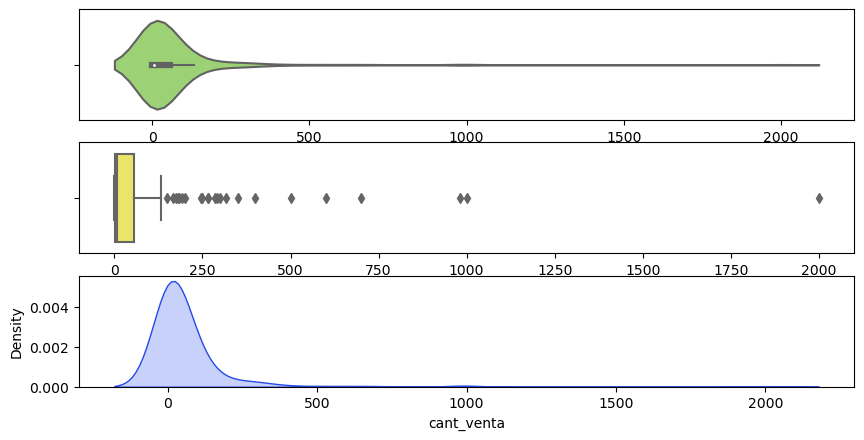

In [76]:
# Definición de los colores para los gráficos
VERDE = '#99e265' #'#5ebc0d'
AZUL = '#2649e8'  #'#17407b'
AMARILLO = '#fff952' #'#efea46'


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad, color=AZUL, shade=True, ax=ax3)

In [77]:
df_cantidad_min = pd.DataFrame(df_ventas.query('cantidad <= 20').cantidad.value_counts())

df_cantidad_min.reset_index(inplace=True)
df_cantidad_min.columns = ['cant_venta', 'cantidad']
df_cantidad_min.describe()


cant_venta      cantidad
count  141.000000    141.000000
mean     3.406383    283.262411
std      4.360001   1736.918682
min      0.000000      1.000000
25%      0.500000      1.000000
50%      1.460000      2.000000
75%      4.200000      5.000000
max     20.000000  16930.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

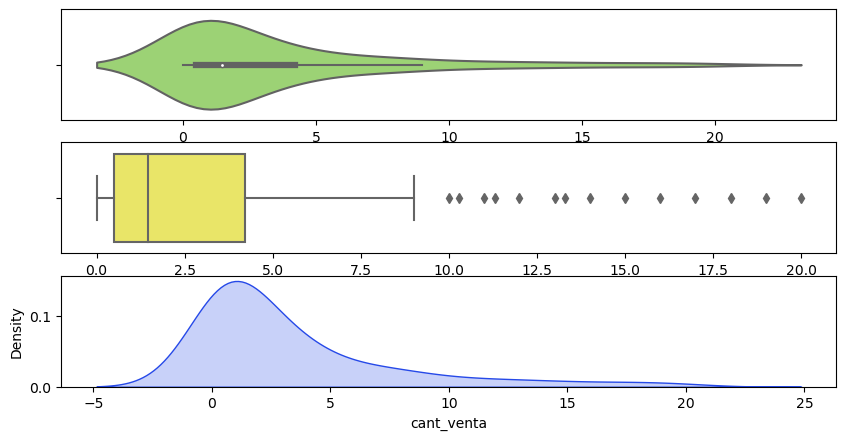

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_min, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_min, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_min, color=AZUL, shade=True, ax=ax3)

In [79]:
df_cantidad_max = pd.DataFrame(df_ventas.query('cantidad > 20').cantidad.value_counts())

df_cantidad_max.reset_index(inplace=True)
df_cantidad_max.columns = ['cant_venta', 'cantidad']
df_cantidad_max.describe()

cant_venta    cantidad
count    97.000000   97.000000
mean    151.716495   10.113402
std     256.667961   23.989093
min      21.000000    1.000000
25%      44.000000    1.000000
50%      74.000000    2.000000
75%     130.000000    6.000000
max    2000.000000  180.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

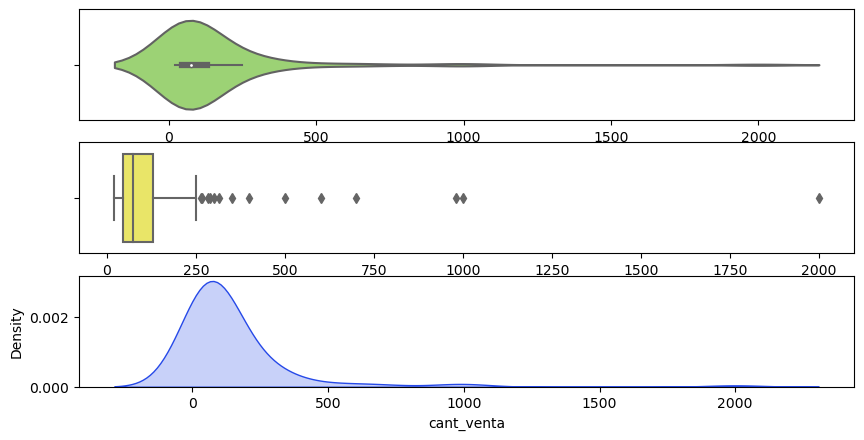

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_max, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_max, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_max, color=AZUL, shade=True, ax=ax3)

In [81]:
df_cantidad_mmax = pd.DataFrame(df_ventas.query('cantidad > 500').cantidad.value_counts())

df_cantidad_mmax.reset_index(inplace=True)
df_cantidad_mmax.columns = ['cant_venta', 'cantidad']
df_cantidad_mmax.describe()

cant_venta  cantidad
count     5.000000  5.000000
mean   1056.000000  1.600000
std     555.589777  0.547723
min     600.000000  1.000000
25%     700.000000  1.000000
50%     980.000000  2.000000
75%    1000.000000  2.000000
max    2000.000000  2.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

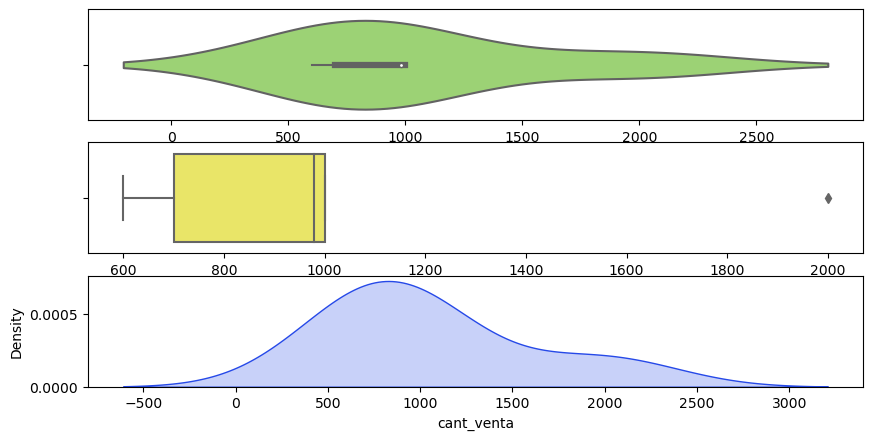

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_mmax, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_mmax, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_mmax, color=AZUL, shade=True, ax=ax3)

In [83]:
df_cantidad_moy = pd.DataFrame(df_ventas.groupby('cod').cantidad.sum()/13)

df_cantidad_moy.reset_index(inplace=True)
df_cantidad_moy.columns = ['cod', 'media_venta']
df_cantidad_moy = df_cantidad_moy.query(' media_venta > 20').sort_values('media_venta', ascending=False)
df_cantidad_moy

cod  media_venta
151   00233   928.615385
1095  02281   257.538462
803   01228   243.846154
298   00432   202.384615
136   00212   197.846154
...     ...          ...
1834  04586    21.230769
1709  04378    20.692308
1174  02899    20.615385
50    00086    20.461538
995   01655    20.076923

[91 rows x 2 columns]

<AxesSubplot:xlabel='media_venta', ylabel='cod'>

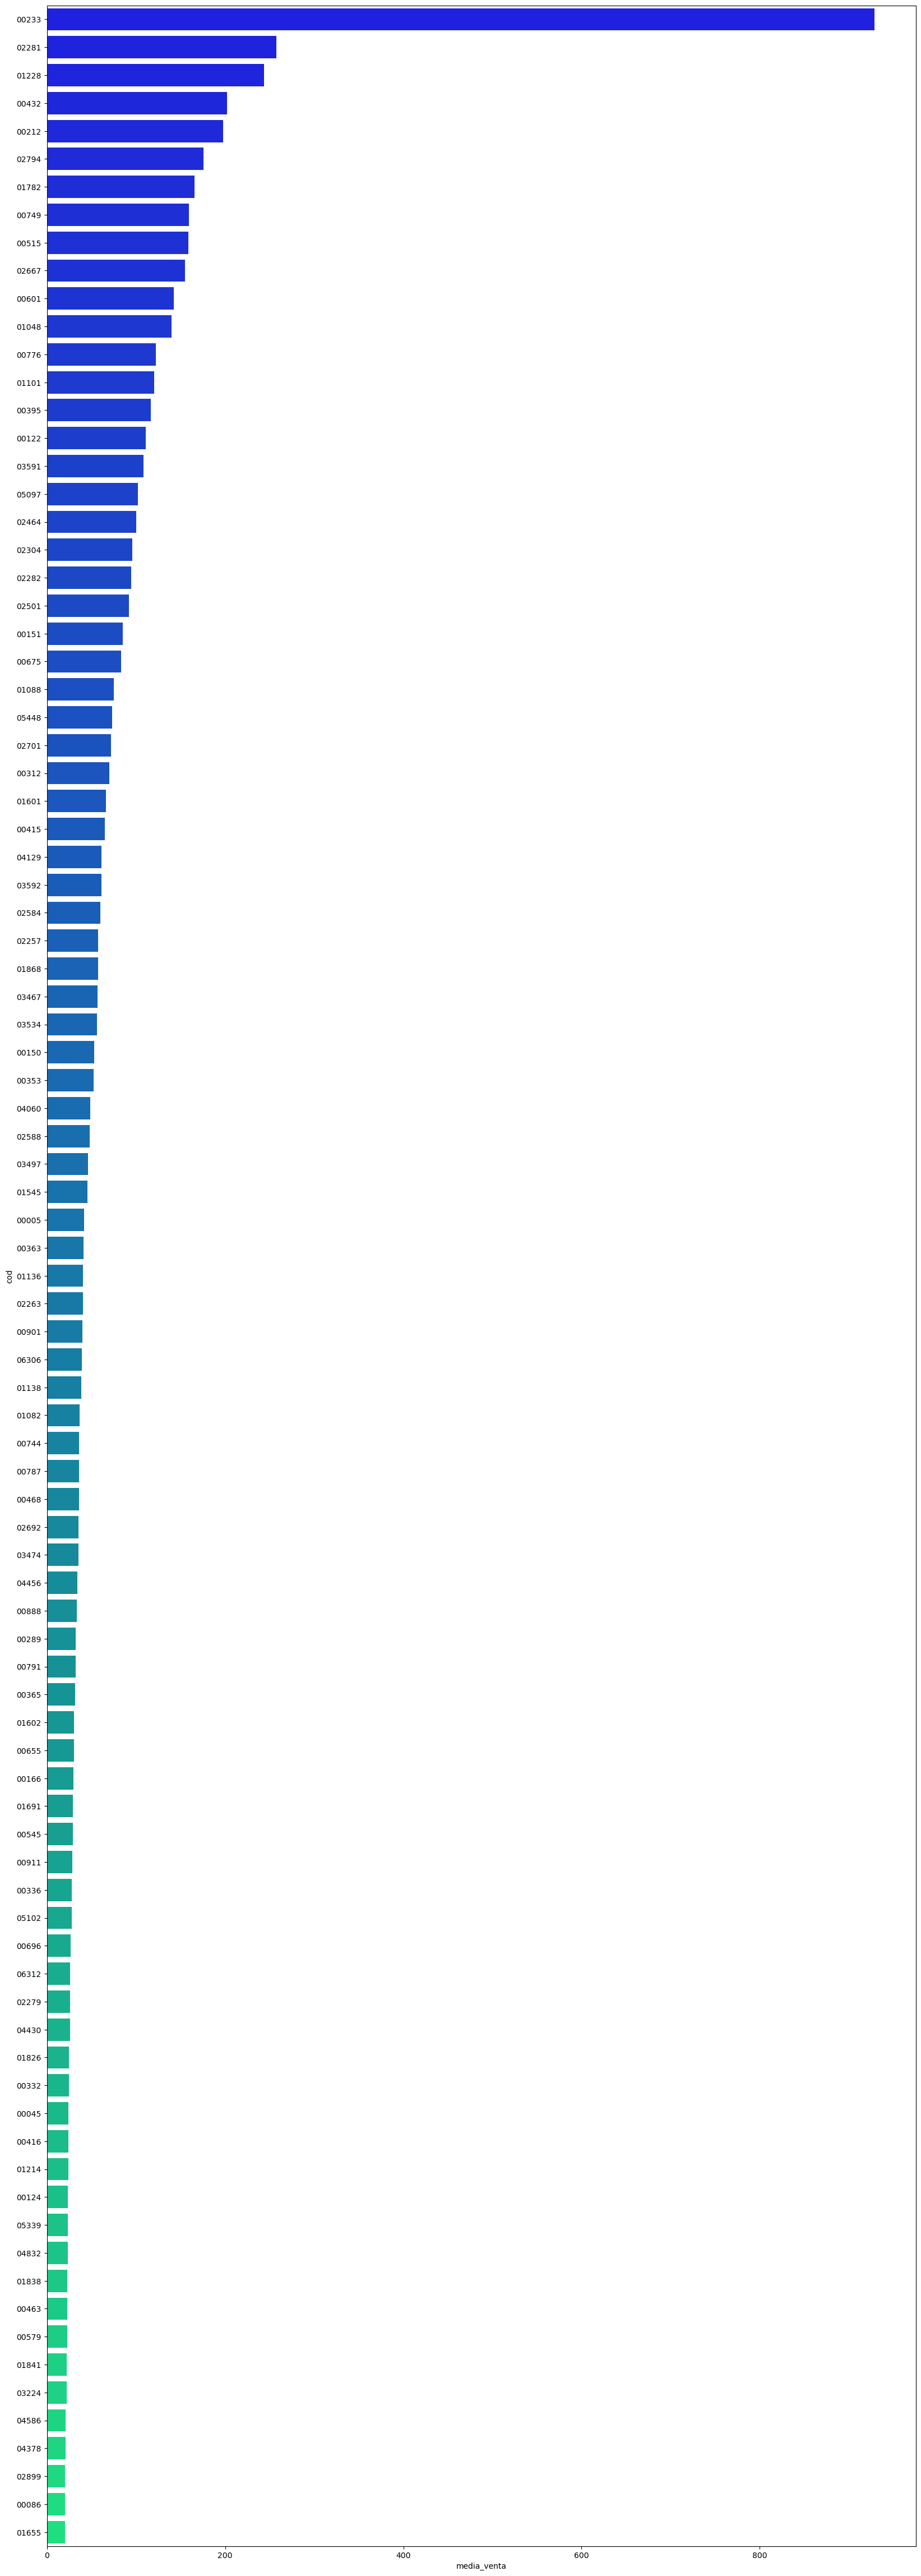

In [84]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(20,60))

#sns.violinplot(x='cod', y='media_venta', data=df_cantidad_moy, color=VERDE, ax=ax1)
#sns.boxplot(x='cod', y='media_venta', data=df_cantidad_moy, color=AMARILLO, ax=ax2)
sns.barplot(y='cod', x='media_venta', data=df_cantidad_moy, palette='winter', ax=ax)

## Ventas por Línea de Producto

In [85]:
# Solo tenemos detalles de ventas a partir de 2021

df_ventas_linea_prod = df_ventas.query('fecha > "2020-12-31"').loc[:,['fecha', 'cod', 'producto', 'cantidad', 'monto_dolar']]
df_ventas_linea_prod

fecha    cod                                           producto  \
10994 2022-01-03  00001    PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO   
10995 2022-01-03  00005                          NIPLE PLASTICO 1" * 13CMS   
10996 2022-01-03  00008            ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON   
10997 2022-01-03  00008            ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON   
10998 2022-01-03  00028    TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E   
...          ...    ...                                                ...   
40916 2022-02-05  00809                          CONFITERIA TORONTO  SAVOY   
40917 2022-02-05  01398           CONFITERIA PASTILLAS CHAO SANDIA/ CEREZA   
40918 2022-02-05  01404                             CONFITERIA OREO TUBITO   
40919 2022-02-05  04072               CERRADURA MANILLA RECTA ALUMINIO TOC   
40920 2022-02-07  05329  GRIFERIA LAVAPLATOS EXTRAIBLE CURVA CAL 41*22C...   

       cantidad  monto_dolar  
10994       1.0     1.842217  
10995       2.0     2.456290  
10996      20.0    76.460554  
10997       1.0     3.823028  
10998       1.0     0.409382  
...         ...          ...  
40916       1.0     0.258696  
40917       1.0     0.360870  
40918       1.0     1.500000  
40919       1.0    15.163043  
40920       1.0    77.223427  

[29927 rows x 5 columns]

In [86]:
df_ventas_linea_prod = pd.merge(df_ventas_linea_prod, df_stock, on=['cod', 'producto'], how='outer')
df_ventas_linea_prod

fecha    cod                                         producto  \
0     2022-01-03  00001  PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO   
1     2022-01-03  00001  PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO   
2     2022-01-12  00001  PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO   
3     2022-01-13  00001  PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO   
4     2022-01-17  00001  PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO   
...          ...    ...                                              ...   
31202        NaT  06360                  BOTAS #43 DE CAUCHO VENUS NEGRA   
31203        NaT  06367  LLAVE 1/4" ESFERICA BRONCE MACHO/HEMBRA GRINACA   
31204        NaT  06371      R. VALVULA ENSAMBLADA PARA MOTOR DE FUMIGAR   
31205        NaT  06384             HIDROJET DE ALTA PRESION 1400W INGCO   
31206        NaT  06385                        CONFITERIA SUSY MAXI 50GR   

       cantidad  monto_dolar                        linea  stock fecha_stock  
0           1.0     1.842217                    GENERALES   15.5  2022-02-16  
1           1.0     2.136461                    GENERALES   15.5  2022-02-16  
2           1.0     2.183168                    GENERALES   15.5  2022-02-16  
3           1.0     1.822314                    GENERALES   15.5  2022-02-16  
4           1.0     1.811088                    GENERALES   15.5  2022-02-16  
...         ...          ...                          ...    ...         ...  
31202       NaN          NaN          SEGURIDAD & HIGIENE    3.0  2022-02-16  
31203       NaN          NaN  LLAVES O VALVULAS METALICAS    3.0  2022-02-16  
31204       NaN          NaN                    GENERALES    6.0  2022-02-16  
31205       NaN          NaN                    GENERALES    1.0  2022-02-16  
31206       NaN          NaN                   CHUCHERIAS    1.0  2022-02-16  

[31207 rows x 8 columns]

In [87]:
df_ventas_linea_prod.groupby(['cod', 'producto']).monto_dolar.sum().sort_values(ascending=False).head(25)

cod    producto                                                                     
00515  REGADOR 1/2" PLASTICO AMARILLO CON NEGRO/NEGRO DAH HAI DIAMETRO 20MTRS           4701.576451
00304  MOTOR DE FUMIGAR BRIGGIES STRATION CON BOMBA FUCHU/SANCHIN 6.5 HP                3472.023576
00212  BAILARINA PUNTO BLANCO AGRO APB                                                  3231.367704
00734  MANGUERA TUBO PEAD 160MM/6" PN10 (150PSI) GEMACA CALIDAD NORVEN (POR METRO)      3106.299050
00911  PUNTO SOLDADURA PEAD DESDE 32MM A 250MM/8"                                       2294.229601
02304  LLAVE PLASTICA 1" ROSCADA                                                        2290.296242
00312  RIEGO ABRAZADERA PLASTICA 40MM * 3/4" AGRO/ F.P/MOM                              2127.943694
00716  MANGUERA PEAD 50MM/2" PN10 (150 PSI) GEMACA CALIDAD NORVEN (ROLLO DE 100 MTS)    2081.506308
03497  RIEGO ABRAZADERA PLASTICA 63MM * 1" AGRO/FP/MOM                                  2036.474439
02257  RIEGO AB

In [88]:
df_ventas_linea_prod.groupby(['cod', 'producto']).cantidad.sum().sort_values(ascending=False).head(25)

cod    producto                                                              
00233  SOLDADURA 3/32 FINA AZUL WEST ARCO KILO(60VARILLAS)                       12072.0
02281  TORNILLO DRYWALL Nº 8*1" POR UNIDAD VERT                                   3348.0
01228  ANILLO REDUCIDO 3/4"*1/2" PLASTICO ROSCADO BLANCO FP AB3.4                 3170.0
00432  ANILLO 3/4" PLASTICO ROSCADO                                               2631.0
00212  BAILARINA PUNTO BLANCO AGRO APB                                            2572.0
02794  ARANDELA PLANA 3/8" NACIONAL TANQUE AUSTRALIANO                            2288.0
01782  CLAVO ACERO 2 1/2 RANURADO (POR UNIDAD)173 KILO                            2150.0
00749  TUERCA 3/8" GALVANIZADA HEX. NC G2 TANQUE AUSTRALIANO                      2030.0
02667  TORNILLO 3/8" * 1 1/4" HEX. NC G2 GALVANIZADO TANQUE AUSTRALIANO           2014.0
00601  SOLDADURA 3/32" GRIS FINA WEST ARCO (POR UNIDAD) 57 KILO                   1847.0
00515  REGADOR 1/2" PLASTICO AMA

In [89]:
df_ventas_linea_prod.groupby(['linea', 'producto']).monto_dolar.sum().sort_values(ascending=False).head(25)

linea                                            producto                                                                     
MOTORES , BOMBAS, ASPIRADORAS Y SOLDADORAS       MOTOR DE FUMIGAR BRIGGIES STRATION CON BOMBA FUCHU/SANCHIN 6.5 HP                3472.023576
ASPERSORES Y REPUESTOS                           BAILARINA PUNTO BLANCO AGRO APB                                                  3231.367704
MANGUERAS DE RIEGO DE POLIETILENO NEGRA          MANGUERA TUBO PEAD 160MM/6" PN10 (150PSI) GEMACA CALIDAD NORVEN (POR METRO)      3106.299050
LLAVES O VALVULAS PLASTICAS                      LLAVE PLASTICA 1" ROSCADA                                                        2290.296242
CONEXIONES PLASTICAS DE RIEGO                    RIEGO ABRAZADERA PLASTICA 40MM * 3/4" AGRO/ F.P/MOM                              2127.943694
MANGUERAS DE RIEGO DE POLIETILENO NEGRA          MANGUERA PEAD 50MM/2" PN10 (150 PSI) GEMACA CALIDAD NORVEN (ROLLO DE 100 MTS)    2081.506308
CONEXIONES PLASTICAS 

In [90]:
df_ventas_linea_prod.groupby(['linea', 'producto']).cantidad.sum().sort_values(ascending=False).head(25)

linea                                            producto                                                        
GENERALES                                        SOLDADURA 3/32 FINA AZUL WEST ARCO KILO(60VARILLAS)                 12072.0
ELEMENTOS DE UNION                               TORNILLO DRYWALL Nº 8*1" POR UNIDAD VERT                             3348.0
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS  ANILLO REDUCIDO 3/4"*1/2" PLASTICO ROSCADO BLANCO FP AB3.4           3170.0
CONEXIONES PLASTICAS DE RIEGO                    ANILLO 3/4" PLASTICO ROSCADO                                         2631.0
ASPERSORES Y REPUESTOS                           BAILARINA PUNTO BLANCO AGRO APB                                      2572.0
ELEMENTOS DE UNION                               ARANDELA PLANA 3/8" NACIONAL TANQUE AUSTRALIANO                      2288.0
NO ASIGNADO                                      CLAVO ACERO 2 1/2 RANURADO (POR UNIDAD)173 KILO                      2150.0
ELEMENTOS D

In [91]:
df_ventas_fecha_linea = df_ventas_linea_prod.groupby(['fecha', 'linea']).monto_dolar.sum() #.sort_values(ascending=False).head(10)

In [92]:
df_ventas_fecha_linea = df_ventas_fecha_linea.reset_index()
#df_ventas_fecha_linea = df_ventas_fecha_linea.set_index('fecha')
df_ventas_fecha_linea

fecha                                              linea  \
0    2021-01-05                                  ALAMBRES Y MALLAS   
1    2021-01-05                             ASPERSORES Y REPUESTOS   
2    2021-01-05                                         CHUCHERIAS   
3    2021-01-05                 CONEXIONES GALVANIZADAS Y CROMADAS   
4    2021-01-05                      CONEXIONES PLASTICAS DE RIEGO   
...         ...                                                ...   
6077 2022-02-15                                 ELEMENTOS DE UNION   
6078 2022-02-15                                          GENERALES   
6079 2022-02-15                              HERRAMIENTAS MANUALES   
6080 2022-02-15  NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS   
6081 2022-02-15                                        NO ASIGNADO   

      monto_dolar  
0       14.317035  
1       78.926155  
2        3.954794  
3       51.972449  
4      169.377226  
...           ...  
6077     1.174292  
6078   108.348584  
6079    18.801743  
6080     1.880174  
6081     0.257081  

[6082 rows x 3 columns]

In [93]:
alt.data_transformers.disable_max_rows()

lineas = alt.Chart(df_ventas_fecha_linea).mark_line().encode(
    x='fecha:T',
    y='monto_dolar:Q',
    color=alt.Color('linea:N'),
    column='linea:N',
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('linea:N', title='Línea de producto'),
        alt.Tooltip('monto_dolar:Q', title='Ventas $ por Línea')
    ]).properties(width=800, height=300)

lineas

alt.Chart(...)

In [94]:
df_ventas_linea = df_ventas_linea_prod.groupby(['linea']).monto_dolar.sum().sort_values(ascending=False).head(10)
df_ventas_linea = df_ventas_linea.reset_index()
df_ventas_linea

linea   monto_dolar
0                      CONEXIONES PLASTICAS DE RIEGO  27742.798200
1            MANGUERAS DE RIEGO DE POLIETILENO NEGRA  21834.273690
2                                          GENERALES  20122.120301
3                                       ELECTRICIDAD  20023.457748
4                                        NO ASIGNADO  15203.969039
5  NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS  10851.237613
6                                   GRIFERIA GENERAL   9936.985956
7    TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS   9084.251870
8                             ASPERSORES Y REPUESTOS   8348.814712
9                        LLAVES O VALVULAS PLASTICAS   7854.684839

In [95]:
total = df_ventas_linea.monto_dolar.sum()
total

151002.59396700718

In [96]:
base = alt.Chart(df_ventas_linea).encode(
    theta=alt.Theta("monto_dolar:Q", stack=True), color=alt.Color("linea:N", legend=None)
)

pie = base.mark_arc(outerRadius=120)
text = base.mark_text(radius=140, size=10).encode(text="linea:N")

pie + text

alt.LayerChart(...)

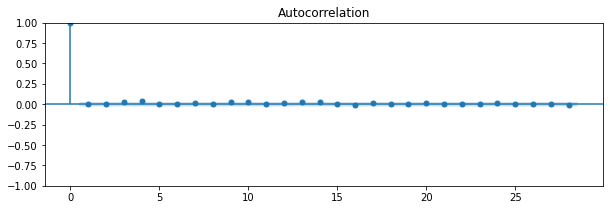

In [97]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(df_ventas_fecha_linea['monto_dolar'], ax=ax, lags=28)
plt.show()

In [98]:
df_ventas_linea_prod.groupby(['linea']).cantidad.sum().sort_values(ascending=False)

linea
ELEMENTOS DE UNION                                   26918.37
GENERALES                                            25147.10
CONEXIONES PLASTICAS DE RIEGO                        15983.00
ELECTRICIDAD                                          9889.95
NO ASIGNADO                                           7966.88
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS       7331.94
NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS     6747.00
ASPERSORES Y REPUESTOS                                4396.00
CONEXIONES GALVANIZADAS Y CROMADAS                    4355.00
PVC TUBERIAS Y ACCESORIOS DE AN                       3284.00
LLAVES O VALVULAS PLASTICAS                           3206.00
CHUCHERIAS                                            2120.00
GRIFERIA GENERAL                                      1482.00
MANGUERAS GENERALES NO DE POLIETILENO                 1194.89
CONSTRUCCIÓN                                           945.22
SEGURIDAD & HIGIENE                                    819.00
HE